# Dissertation Proposal

Kendra Wyant [](https://orcid.org/0000-0002-0767-7589)  
December 31, 2024

Insert abstract here

In [ ]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(tidyposterior))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))


path_models_ema <- format_path("studydata/risk/models/ema")
path_processed_ema <- format_path("studydata/risk/data_processed/ema")
path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_processed_lag <- format_path("studydata/risk/data_processed/lag")
path_shared <- format_path("studydata/risk/data_processed/shared")
# path_input <- format_path("studydata/risk/chtc/ema")

options(knitr.kable.NA = '')

In [ ]:
# read in ema tibbles for in-line code
disposition <- read_csv(file.path(path_processed_ema, "disposition.csv"), 
                        col_types = "ccDDcccccccccc")
screen <- read_csv(file.path(path_shared, "screen.csv"), 
                   col_types = cols()) |>
  filter(subid %in% subset(disposition, analysis == "yes")$subid) |> 
  mutate(across(dsm5_1:dsm5_11, ~ recode(., "No" = 0, "Yes" = 1))) |>  
  rowwise() |>  
  mutate(dsm5_total = sum(c(dsm5_1, dsm5_2, dsm5_3, dsm5_4, dsm5_5, dsm5_6, dsm5_7, 
                              dsm5_8, dsm5_9, dsm5_10, dsm5_11))) |>  
  ungroup()
lapses <- read_csv(file.path(path_shared, "lapses.csv"), col_types = cols()) |>
  filter(exclude == FALSE)

# lapse labels
labels_week <- read_csv(file.path(path_processed_ema, "labels_1week.csv"), col_types = cols())
labels_day <- read_csv(file.path(path_processed_ema, "labels_1day.csv"), col_types = cols())
labels_hour <- read_csv(file.path(path_processed_ema, "labels_1hour.csv"), col_types = cols())


# Predictions data
preds_week<- read_rds(file.path(path_models_ema, "outer_preds_1week_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)
preds_day<- read_rds(file.path(path_models_ema, "outer_preds_1day_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)
preds_hour<- read_rds(file.path(path_models_ema, "outer_preds_1hour_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)

auc_week <- read_rds(file.path(path_models_ema, "outer_metrics_1week_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))
auc_day <- read_rds(file.path(path_models_ema, "outer_metrics_1day_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))
auc_hour <- read_rds(file.path(path_models_ema, "outer_metrics_1hour_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))

auc_week_baseline <- read_rds(file.path(path_models_ema, "outer_metrics_1week_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc")) 
auc_day_baseline <- read_rds(file.path(path_models_ema, "outer_metrics_1day_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc")) 
auc_hour_baseline <- read_rds(file.path(path_models_ema, "outer_metrics_1hour_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc"))

# ROC curves
roc_week <- preds_week |>  
  roc_curve(prob, truth = label) |>  
  mutate(model = "1week")

roc_day <- preds_day |>  
  roc_curve(prob, truth = label) |>  
  mutate(model = "1day")

roc_hour <- preds_hour|>  
  roc_curve(prob, truth = label) |>  
  mutate(model = "1hour")

roc_all <- roc_week |>  
  bind_rows(roc_day) |>  
  bind_rows(roc_hour)

# PR curves
pr_week <- preds_week |>  
  pr_curve(prob, truth = label) |>  
  mutate(model = "1week")

pr_day <- preds_day |>  
  pr_curve(prob, truth = label) |>  
  mutate(model = "1day")

pr_hour <- preds_hour|>  
  pr_curve(prob, truth = label) |>  
  mutate(model = "1hour")

pr_all <- pr_week |>  
  bind_rows(pr_day) |>  
  bind_rows(pr_hour)

# metrics
metrics_week <- read_csv(file.path(path_models_ema, "test_metrics_1week_0_v5_nested.csv"))

Rows: 180 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): .metric
dbl (2): outer_split_num, .estimate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 180 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): .metric
dbl (2): outer_split_num, .estimate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 180 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): .metric
dbl (2): outer_split_num, .estimate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
# read in lag tibbles for in-line code

test_metrics_all_pp_perf <- read_csv(here::here(path_models_lag, "test_metrics_all_pp_perf.csv"), 
                                     col_types = cols())

ci_baseline_lag <- read_csv(here::here(path_models_lag, "ci_baseline.csv"), 
                        col_types = cols())

ci_lag <- read_csv(here::here(path_models_lag, "ci_lag.csv"), col_types = cols())

pp_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"), col_types = cols())

pp_dem_contrast <- read_csv(here::here(path_models_lag, "pp_dem_contrast_all.csv"), col_types = cols())

screen <- read_csv(here::here(path_processed_lag, "dem_tibble.csv"),
                   col_types = cols())

lapses_per_subid <- read_csv(here::here(path_processed_lag, "lapse_tibble.csv"),
                             col_types = cols())

# 1. Introduction

# 2. Machine Learning Models for Temporally Precise Lapse Prediction in Alcohol Use Disorder

## 2.1 Introduction

Over 30 million adults in the United States (US) had an active alcohol use disorder (AUD) in 2021, and 23.3% reported engaging in past-month binge drinking ([SAMHSA Center for Behavioral Health Statistics and Quality, 2021](#ref-samhsacenterforbehavioralhealthstatisticsandquality2021NSDUHDetailed2021)). Alcohol ranks as the third leading preventable cause of death in the US, accounting for approximately 140,000 fatalities ([Centers for Disease Control and Prevention (CDC), n.d.](#ref-centersfordiseasecontrolandpreventioncdcAnnualAverageUnited)) and economic costs that exceed \$249 billion annually ([Substance Abuse and Mental Health Services Administration (US) & Office of the Surgeon General (US), 2016](#ref-substanceabuseandmentalhealthservicesadministrationusFacingAddictionAmerica2016)).

Existing clinician-delivered treatments for AUD that were derived from Marlatt’s relapse prevention model ([Marlatt & Gordon, 1985](#ref-marlattRelapsePreventionMaintenance1985)) are effective when delivered (e.g., cognitive-behavioral therapy, mindfulness-based relapse prevention ([Bowen et al., 2014](#ref-bowenRelativeEfficacyMindfulnessBased2014))). Unfortunately, fewer than 1 in 20 adults with an active AUD receive any treatment ([SAMHSA Center for Behavioral Health Statistics and Quality, 2021](#ref-samhsacenterforbehavioralhealthstatisticsandquality2021NSDUHDetailed2021)). Even more concerning, failure to access treatment is associated with demographic factors including race, ethnicity, geographic region, and socioeconomic status, which further increase mental health disparities ([Office of the Surgeon General (US) et al., 2001](#ref-officeofthesurgeongeneralusMentalHealthCulture2001)). This treatment gap and associated disparities stem from well-known barriers to receiving clinician-delivered mental healthcare related to affordability, accessibility, availability, and acceptability ([Jacobson et al., 2022](#ref-jacobsonDigitalTherapeuticsMental2022)).

Digital therapeutics may help to overcome these barriers associated with in-person, clinician-delivered treatments. Digital therapeutics provide evidence-based interventions and other supports via smartphones to prevent, treat, or manage a medical disorder, either independently or in conjunction with traditional treatments ([Jacobson et al., 2022](#ref-jacobsonDigitalTherapeuticsMental2022)). They offer highly scalable, on-demand therapeutic support that is accessible whenever and wherever it is needed most. Several large, randomized controlled trials have confirmed that digital therapeutics for AUD improve clinical outcomes ([Campbell et al., 2014](#ref-campbellInternetdeliveredTreatmentSubstance2014); [Gustafson et al., 2014](#ref-gustafsonSmartphoneApplicationSupport2014); [Jacobson et al., 2022](#ref-jacobsonDigitalTherapeuticsMental2022)). Additionally, US adults (including patients with AUD ([Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023))) display high rates of smartphone ownership (over 85% in 2021), with minimal variation across race, ethnicity, socioeconomic status, and geographic settings ([Center, 2021](#ref-pewresearchcenterMobileFactSheet2021)). Therefore, digital therapeutics may not only mitigate in-person treatment barriers but also combat associated disparities ([Jacobson et al., 2022](#ref-jacobsonDigitalTherapeuticsMental2022)).

### 2.1.1 Improving Digital Therapeutics via Personal Sensing

Despite the documented benefits of digital therapeutics, their full potential has not yet been realized. Patients often don’t engage with digital therapeutics as developers intended, and long-term engagement may not be sustained or matched to patients’ needs ([Hatch et al., 2018](#ref-hatchExpertConsensusSurvey2018); [Jacobson et al., 2022](#ref-jacobsonDigitalTherapeuticsMental2022)). The substantial benefits of digital therapeutics come from easy, 24/7 access to their intervention and other support modules. However, the burden falls primarily on the patient to identify the most appropriate modules for them in that specific moment during their recovery.

This difficulty is magnified by the dynamic, chronic, and relapsing nature of AUD ([Brandon et al., 2007](#ref-brandonRelapseRelapsePrevention2007)). Numerous risk and protective factors interact in complex, non-linear ways to influence the probability, timing, and severity of relapse (i.e., a goal-inconsistent return to frequent, harmful alcohol use) ([Witkiewitz & Marlatt, 2007](#ref-witkiewitzModelingComplexityPosttreatment2007)). Factors such as urges, mood, lifestyle imbalances, self-efficacy, and motivation can all vary over time. Social networks may evolve to become more protective or risky, and high-risk situations can arise unexpectedly. Consequently, both relapse risk and the factors driving that risk fluctuate over time.

Successful, continuous monitoring of risk for relapse and its contributing factors would enable patients to adapt their lifestyle, behaviors, and supports to their changing needs. Successful monitoring could also direct patients to engage with the most appropriate digital therapeutic modules, addressing the unique risks present at any given moment throughout their recovery. Such continuous monitoring is now feasible via personal sensing (i.e., in-situ data collection via sensors embedded in individuals’ daily lives) ([Bae et al., 2018](#ref-baeMobilePhoneSensors2018); [Chih et al., 2014](#ref-chihPredictiveModelingAddiction2014); [Epstein et al., 2020](#ref-epsteinPredictionStressDrug2020); [Moshontz et al., 2021](#ref-moshontzProspectivePredictionLapses2021); [Soyster et al., 2022](#ref-soysterPooledPersonspecificMachine2022); [Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023)).

The current project focuses explicitly on using ecological momentary assessment (EMA) for monitoring risk of return to alcohol use. EMA can be easily implemented with only a smartphone. Moreover, comparable item responses can be collected consistently across different hardware and operating systems. Thus, EMA can be incorporated essentially identically into any existing or future smartphone-based digital therapeutic. EMA, like other personal sensing methods, can support the frequent, in-situ, longitudinal measurement necessary for monitoring fluctuating relapse risk. Long-term monitoring with EMA has been well-tolerated by individuals with AUD ([Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023)). Additionally, previous research has validated the use of EMA to measure known risk and protective factors for relapse, including craving ([Dulin & Gonzalez, 2017](#ref-dulinSmartphonebasedMomentaryIntervention2017)), mood ([Russell et al., 2020](#ref-russellAffectRelativeDayLevel2020)), stressors ([Wemm et al., 2019](#ref-wemmDaydayProspectiveAnalysis2019)), positive life events ([Dvorak et al., 2018](#ref-dvorakTensionReductionAffect2018)), and motivation/efficacy ([Dvorak et al., 2014](#ref-dvorakEcologicalMomentaryAssessment2014)). EMA offers privileged access into these and other subjective factors that may be difficult to quantify reliably through other sensing methods.

### 2.1.2 Promising Preliminary Research

Preliminary research is now emerging that uses EMA responses as features in machine learning models to predict the probability of future alcohol use ([Bae et al., 2018](#ref-baeMobilePhoneSensors2018); [Chih et al., 2014](#ref-chihPredictiveModelingAddiction2014); [Soyster et al., 2022](#ref-soysterPooledPersonspecificMachine2022); [Walters et al., 2021](#ref-waltersUsingMachineLearning2021)). This research is important because it rigorously required strict temporal ordering necessary for true prediction, with features measured before alcohol use outcomes. It also used resampling methods (e.g., cross-validation) that prioritize model generalizability to increase the likelihood these models will perform well with new people.

Despite this initial promise, several important limitations exist. Some prediction models have been trained using convenience samples (e.g., college students) ([Bae et al., 2018](#ref-baeMobilePhoneSensors2018); [Soyster et al., 2022](#ref-soysterPooledPersonspecificMachine2022)). Other models have been developed to predict hazardous alcohol use in non-treatment-seeking populations ([Walters et al., 2021](#ref-waltersUsingMachineLearning2021)). In both these instances, features that predict planned or otherwise intentional alcohol use among individuals not motivated to change their behavior may not generalize to people in AUD recovery. Moreover, individuals who have not yet begun to contemplate and/or commit to behavior change regarding their alcohol use are unlikely to use digital therapeutics designed for AUD recovery ([Prochaska et al., 1992](#ref-prochaskaSearchHowPeople1992)).

A handful of other models have been trained to predict putative precursors of substance use, such as craving ([Burgess-Hull et al., 2022](#ref-burgess-hullTrajectoriesCravingMedicationassisted2022); [Dumortier et al., 2016](#ref-dumortierClassifyingSmokingUrges2016)) and stress ([Epstein et al., 2020](#ref-epsteinPredictionStressDrug2020)). Although craving and stress may be associated with substance use, their relationships with relapse are complex, inconsistent, and not always very strong ([Fronk et al., 2020](#ref-fronkStressAllostasisSubstance2020); [Sayette, 2016](#ref-sayetteRoleCravingSubstance2016)). For these reasons, we believe that explicit substance use may be a better target for prediction.

With respect to explicit substance use, we also argue that models that predict lapses (i.e., single instances of goal-inconsistent substance use) rather than relapse may be preferred. Lapses are clearly defined, observable, and have temporally precise onsets and offsets. Conversely, definitions of relapse vary widely ([Witkiewitz & Marlatt, 2007](#ref-witkiewitzModelingComplexityPosttreatment2007)), and it is difficult to delineate precisely when relapse begins or ends. Lapses always precede relapse and therefore may serve as an early warning sign for intervention. Finally, maladaptive responses to a lapse (e.g., abstinence violation effects; ([Marlatt & Gordon, 1985](#ref-marlattRelapsePreventionMaintenance1985))) can undermine recovery by themselves, making lapses clinically meaningful events to detect and address.

An early alcohol lapse prediction model developed by Gustafson and colleagues ([Chih et al., 2014](#ref-chihPredictiveModelingAddiction2014)) provided the foundation on which our current project builds. Participants completed EMAs once per week for 8 months while using a digital therapeutic after discharge from an inpatient treatment program for AUD. These EMAs were used as features in a machine learning model to predict lapses. However, the temporal precision for both the features and outcome was coarse. Model predictions were updated only once per week at most, and lapse onsets could occur anytime within the next two weeks. This coarseness restricts the model from being used to implement *just-in-time* interventions (e.g., guided mindfulness or other stress reduction techniques, urge surfing) that are well-suited to digital therapeutics.

### 2.1.3 The Current Study

The current study addresses these limitations of previously developed prediction models. We trained our models using participants in early recovery from moderate to severe AUD who reported a goal of alcohol abstinence. We developed three separate models that provide hour-by-hour probabilities of a future lapse back to alcohol use with increasing temporal precision: lapses in the next week, next day, and next hour. Model features were engineered from raw scores and longitudinal change in responses to 4X daily EMAs. These features were derived to measure theoretically-implicated risk factors and contexts that have considerable support as predictors of lapses including past use, craving, past pleasant events, past and future risky situations, past and future stressful events, emotional valence and arousal, and self-efficacy ([Fronk et al., 2020](#ref-fronkStressAllostasisSubstance2020); for reviews, see [Marlatt & Gordon, 1985](#ref-marlattRelapsePreventionMaintenance1985); [Witkiewitz & Marlatt, 2007](#ref-witkiewitzModelingComplexityPosttreatment2007)).

In this study, we characterize the performance of these three prediction models in held-out data (i.e., for observations from participants who were not used to train the models). We also evaluated the relative feature importance of key relapse prevention constructs in the models as part of the model validation process and to contribute to the relapse prevention literature. This research represents an important step toward the development of a “smart” (machine learning guided) sensing and prediction system that can be embedded within a digital therapeutic both to identify periods of peak lapse risk and to recommend specific supports to address factors contributing to this risk.

## 2.2 Method

### 2.2.1 Transparency and Openness

We adhere to research transparency principles that are crucial for robust and replicable science. We reported how we determined the sample size, all data exclusions, all manipulations, and all study measures. Finally, our data, analysis scripts, annotated results, questionnaires, and other study materials are publicly available (<https://osf.io/w5h9y/>).

Our study design and analyses were not pre-registered. However, we restricted many researcher degrees of freedom via cross-validation. Cross-validation inherently includes replication; models are fit on held-in training sets, decisions are made in held-out validation sets, and final performance is evaluated on held-out test sets.

### 2.2.2 Participants

We recruited 151 participants in early recovery (1-8 weeks of abstinence) from AUD in Madison, Wisconsin, US. This sample size was determined based on traditional power analysis methods for logistic regression ([Hsieh, 1989](#ref-hsiehSampleSizeTables1989)) because comparable approaches for machine learning models have not yet been validated. Participants were recruited through print and targeted digital advertisements and partnerships with treatment centers. We required participants:

1.  were age 18 or older,
2.  could write and read in English,
3.  had at least moderate AUD (\>= 4 self-reported DSM-5 symptoms),
4.  were abstinent from alcohol for 1-8 weeks, and
5.  were willing to use a single smartphone (personal or study provided) while on study.

We also excluded participants exhibiting severe symptoms of psychosis or paranoia.

### 2.2.3 Procedure

Participants completed five study visits over approximately three months. After an initial phone screen, participants attended an in-person screening visit to determine eligibility, complete informed consent, and collect self-report measures. Eligible, consented participants returned approximately one week later for an intake visit. Three additional follow-up visits occurred about every 30 days that participants remained on study. Participants were expected to complete four daily EMAs while on study. Other personal sensing data streams (geolocation, cellular communications, sleep quality, and audio check-ins) were collected as part of the parent grant’s aims (R01 AA024391).

### 2.2.4 Measures

#### 2.2.4.1 Ecological Momentary Assessments

Participants completed four brief (7-10 questions) EMAs daily. The first and last EMAs of the day were scheduled within one hour of participants’ typical wake and sleep times. The other two EMAs were scheduled randomly within the first and second halves of their typical day, with at least one hour between EMAs. Participants learned how to complete the EMA and the meaning of each question during their intake visit.

On all EMAs, participants reported dates/times of any unreported past alcohol use. Next, participants rated the intensity of four recent experiences:

-   craving \[“How intense was your greatest urge to drink?”\],
-   risky situations \[“Did you encounter any risky situations (people, places, or things)? If yes, rate the intensity of the situation.”\],
-   stressful events \[“Has a hassle or stressful event occurred? If yes, rate the intensity of the event.”\],
-   pleasant events \[Has a pleasant or positive event occurred? If yes, rate the intensity of the event.”\].

For each of these experiences, participants rated the maximum intensity since their last EMA on a 12-point ordinal scale (mid- and end-point anchors of “Mild”, “Moderate”, and “Strong”). If they did not experience an event since their last EMA, participants selected “No” to indicate that no experience occurred for that respective question.

Next, participants rated their current affect using 11-point bipolar scales measuring valence (end-point anchors of “Unpleasant/Unhappy” to “Pleasant/Happy”) and arousal (end-point anchors of “Calm/Sleepy” to “Aroused/Alert”).

On the first EMA each day, participants used an 11-point bipoloar scale (end-point anchors of “Very Unlikely” to “Very Likely”) to rate the likelihood of:

-   future risky situations \[“How likely are you to encounter risky situations (people, places, or things) within the next week?”\],
-   future stressful events \[“How likely are you to encounter a stressful event within the next week?”\],
-   abstinence efficacy \[“How likely are you to drink any alcohol within the next week?”\].

#### 2.2.4.2 Individual Differences

We collected self-report information about demographics (age, sex, race, ethnicity, education, marital status, employment, and income) and clinical characteristics (AUD milestones, number of quit attempts, lifetime AUD treatment history, lifetime receipt of AUD medication, DSM-5 AUD symptom count, and current drug use ([WHO ASSIST Working Group, 2002](#ref-whoassistworkinggroupAlcoholSmokingSubstance2002))). This information was collected primarily to characterize the sample and to evaluate the diversity of the training data. We also included demographic features in our models to quantify the importance of relapse prevention constructs beyond these static characteristics, given known disparities in AUD and other health outcomes ([Jacobson et al., 2022](#ref-jacobsonDigitalTherapeuticsMental2022))[1].

### 2.2.5 Data Analytic Strategy

Data preprocessing, modeling, and Bayesian analyses were done in R using the tidymodels ecosystem ([Kuhn & Wickham, 2020](#ref-kuhnTidymodelsCollectionPackages2020)). Models were trained and evaluated using high-throughput computing resources provided by the University of Wisconsin Center for High Throughput Computing ([Center for High Throughput Computing, 2006](#ref-chtc)).

#### 2.2.5.1 Lapse Labels

We predicted future lapses in three prediction window widths: one week, one day, and one hour. Prediction windows were updated hourly. All classification models provide hour-by-hour predictions of future lapse probability for all three window widths.

For each participant, the first prediction window for all three widths began at midnight on their second day of participation and ended one week, one day, or one hour later. This ensured at least 24 hours of past EMAs for future lapse prediction in these first windows. Subsequent windows for each participant were created by repeatedly rolling the window start/end forward one hour until the end of their study participation (i.e., each participant’s last prediction window started one week, one day, or one hour before their last recorded EMA).

We labeled each prediction window as *lapse* or *no lapse* using participants’ reports from the EMA question “Have you drank any alcohol that you have not yet reported?”. If participants answered yes to this question, they entered the date and hour of the start and end of the drinking episode. During monthly follow-up sessions, participants could review and correct their lapses reported by EMA and report to staff any additional lapses.

A prediction window was labeled *lapse* if the start date/hour of any drinking episode fell within that window. A window was labeled *no lapse* if no alcohol use occurred within that window +/- 24 hours. If no alcohol use occurred within the window but did occur within 24 hours of the start or end of the window, the window was excluded. We used this conservative 24-hour fence for labeling windows as *no lapse* (vs. excluded) to increase the fidelity of these labels. Given that most windows were labeled *no lapse*, and the outcome was highly unbalanced, it was not problematic to exclude some *no lapse* events to further increase confidence in those labels.

#### 2.2.5.2 Feature Engineering

Features were calculated using only data collected before the start of each prediction window to ensure our models were making true *future predictions*. We created features for both baseline and full models. The baseline models were developed to determine how well we could predict lapses using a simple model based only on the participants’ histories of previous lapses. The full models used all EMA responses combined with demographic and day/time features.

The baseline models had only one dummy-coded feature: lapse frequency (high vs. low). The median number of lapses across participants during the study period was 1. Therefore, the lapse frequency feature was coded low when the participant had a history of 1 or fewer lapses before that prediction window. This feature was coded high when the participant had more than 1 lapse before that window.

Features for the full model were derived from three sources: 1) common demographic characteristics, 2) day of the week and hour of the day at prediction window onset, and 3) previous EMA responses. We created a quantitative feature for age, and dummy-coded features for sex (male vs. female), race/ethnicity (White/Non-Hispanic vs. other), marital status (never married vs. married vs. other), and education (high school or less vs. some college vs. 4-year degree or more). We created dummy-coded features to indicate time of day (5pm - midnight vs. any other time) and day of week that the prediction window began.

We created raw EMA features for varying scoring epochs before the start of the prediction window for all EMA items excluding the alcohol use question. For the six EMA questions that appeared on all four daily EMAs, we used five scoring epochs of 12, 24, 48, 72, and 168 hours. For the three EMA questions that only appeared on the morning EMA, we used three scoring epochs of 48, 72, and 168 hours. Raw features included min, max, and median scores for each EMA question across all EMAs in each epoch for that participant. We calculated change features by subtracting the participant’s mean score for each EMA question (using all EMAs collected before the start of the prediction window) from the associated raw feature. These change features allowed us to capture within-subject effects by comparing recent EMA responses relative to an individual’s own baseline. For both raw and change features, the feature was set to missing (and later imputed; see below) if no responses to the specific EMA question were provided by the participant within the associated scoring epoch.

We also created raw and change features based on the most recent response for each EMA question (excluding the alcohol use question). This generated two features for each EMA question: 1) raw value of the most recent previous response, and 2) difference between that raw value and the mean response to that EMA question over all EMAs collected before that prediction window.

We also calculated raw and change rate features from previously reported lapses. We calculated lapse rate features using the same five scoring epochs described earlier. Raw lapse rate features were generated by dividing the total number of previously observed lapses within a scoring epoch by the duration of that epoch. For change rate features, we subtracted the rate of previous lapses for that participant (i.e., total number of lapses while on-study divided by total hours on-study before the prediction window) from their associated raw lapse rate. We employed a similar approach to calculate raw and change rate of missing EMAs (i.e., number of full EMA surveys that were requested but not completed in a scoring epoch / duration of epoch).

Other generic feature engineering steps included: 1) imputing missing data (median imputation for numeric features, mode imputation for nominal features); 2) dummy coding for nominal features; and 3) removing zero-variance features. Medians/modes for missing data imputation and identification of zero variance features were derived from held-in (training) data and applied to held-out (validation and test) data (see Cross-validation section below). We recognize that median/mode imputation is a coarse method for handling missing data; however, computational costs of more sophisticated methods (e.g., KNN imputation, multiple imputation) were not practical for this study. A sample feature engineering script (i.e., tidymodels recipe) containing all feature engineering steps is available on our OSF study page.

#### 2.2.5.3 Model Training and Evaluation

##### 2.2.5.3.1 Statistical Algorithm and Hyperparameters.

We trained and evaluated six separate classification models: one baseline and one full model for each prediction window (week, day, and hour). We initially considered four well-established statistical algorithms (XGBoost, Random Forest, K-Nearest Neighbors, and Elastic Net) that vary across characteristics expected to affect model performance (e.g., flexibility, complexity, handling higher-order interactions natively) ([Kuhn & Johnson, 2018](#ref-kuhnAppliedPredictiveModeling2018)). However, preliminary exploratory analyses suggested that XGBoost consistently outperformed the other three algorithms[2]. Furthermore, the Shapley Additive Explanations (SHAP) method, which we planned to use for explanatory analyses of feature importance in our full models, is optimized for XGBoost. Consequently, we focused our primary model training and evaluation on the XGBoost algorithm only.

Candidate XGBoost model configurations differed across sensible values for the hyperparameters mtry, tree depth, and learning rate using grid search. All configurations used 500 trees with early stopping to prevent over-fitting. All other hyperparameters were set to tidymodels package defaults. Candidate model configurations also differed on outcome resampling method (i.e., up-sampling and down-sampling of the outcome using majority/no lapse to minority/lapse ratios ranging from 1:1 to 5:1). We calibrated predicted probabilities using the beta distribution to support optimal decision-making under variable outcome distributions ([Kull et al., 2017](#ref-kullSigmoidsHowObtain2017)).

Model training and evaluation used all participants (N = 151), regardless if they had any positive labels (i.e., lapses) because XGBoost itself does not use grouping of observations within participants. This grouping is handled instead by a participant-grouped cross-validation procedure (below).

##### 2.2.5.3.2 Performance Metric.

Our primary performance metric for model selection and evaluation was area under the Receiver Operating Characteristic Curve (auROC) ([Kuhn & Johnson, 2018](#ref-kuhnAppliedPredictiveModeling2018)). auROC indexes the probability that the model will predict a higher score for a randomly selected positive case (lapse) relative to a randomly selected negative case (no lapse). This metric was selected because it 1) combines sensitivity and specificity, which are both important characteristics for clinical implementation; 2) is an aggregate metric across all decision thresholds, which is important because optimal decision thresholds may differ across settings and goals; and 3) is unaffected by class imbalance, which is important for comparing models with differing prediction window widths and levels of class imbalance.

##### 2.2.5.3.3 Cross-validation.

We used participant-grouped, nested cross-validation for model training, selection, and evaluation with auROC. Grouped cross-validation assigns all data from a participant as either held-in or held-out to avoid bias introduced when predicting a participant’s data from their own data. Nested cross-validation uses two nested loops for dividing and holding out folds: an outer loop, where held-out folds serve as *test sets* for model evaluation; and inner loops, where held-out folds serve as *validation sets* for model selection. Importantly, these sets are independent, maintaining separation between data used to train the models, select the best models, and evaluate those best models. Therefore, nested cross-validation removes optimization bias from the evaluation of model performance in the test sets and can yield lower variance performance estimates than single test set approaches ([Jonathan et al., 2000](#ref-jonathanUseCrossvalidationAssess2000)).

We used 1 repeat of 10-fold cross-validation for the inner loops and 3 repeats of 10-fold cross-validation for the outer loop. Best model configurations were selected using median auROC across the 10 *validation sets*. Final performance evaluation of those best model configurations used median auROC across the 30 *test sets*. We report median auROC for our six best model configurations in the test sets. In addition, we report other key performance metrics for the best full model configurations including sensitivity, specificity, balanced accuracy, positive predictive value (PPV), and negative predictive value (NPV) from the test sets ([Kuhn & Johnson, 2018](#ref-kuhnAppliedPredictiveModeling2018)).

#### 2.2.5.4 Bayesian Estimation of auROC and Model Comparisons

We used a Bayesian hierarchical generalized linear model to estimate the posterior probability distributions and 95% Bayesian confidence intervals (CIs) for auROC for the six best models. Bayesian analyses were accomplished using the tidyposterior ([Kuhn, 2022](#ref-kuhnTidyposteriorBayesianAnalysis2022)) and rstanarm ([Goodrich et al., 2023](#ref-goodrichRstanarmBayesianApplied2023)) packages in R. Following recommendations from the rstanarm team and others ([Gabry & Goodrich, 2023](#ref-gabryPriorDistributionsRstanarm2023); [RStudio Team, 2020](#ref-rstudioteamRStudioIntegratedDevelopment2020)), we used the rstanarm default autoscaled, weakly informative, data-dependent priors that take into account the order of magnitude of the variables to provide some regularization to stabilize computation and avoid over-fitting. Specifically, the priors were set as follows: residual standard deviation ~ normal(location=0, scale=exp(2)), intercept (after centering predictors) ~ normal(location=2.3, scale=1.3), the two coefficients for window width contrasts ~ normal (location=0, scale=2.69), and covariance ~ decov(regularization=1, concentration=1, shape=1, scale=1).

To estimate the probability that the full model outperformed the baseline model, we regressed the auROCs (logit transformed) from the 30 test sets for each model as a function of model type (baseline vs. full). To determine the probability that full models’ performances differed systematically from each other, we regressed the auROCs (logit transformed) from the 30 test sets for each full model as a function of prediction window width (week vs. day vs. hour). Following recommendations from the tidymodels team ([Kuhn, 2022](#ref-kuhnTidyposteriorBayesianAnalysis2022)), we set two random intercepts: one for the repeat, and another for the fold within repeat (folds are nested within repeats for 3x10-fold cross-validation). We report the 95% (equal-tailed) Bayesian CIs from the posterior probability distributions for our models’ auROCs. We also report 95% (equal-tailed) Bayesian CIs for the differences in performance associated with the Bayesian comparisons.

#### 2.2.5.5 Shapley Additive Explanations for Feature Importance

We computed Shapley Values ([Lundberg & Lee, 2017](#ref-lundbergUnifiedApproachInterpreting2017)) to provide a consistent, objective explanation of the importance of categories of features (based on EMA questions) across our three full models. Shapley values possess several useful properties including: Additivity (Shapley values for each feature can be computed independently and summed); Efficiency (the sum of Shapley values across features must add up to the difference between predicted and observed outcomes for each observation); Symmetry (Shapley values for two features should be equal if the two features contribute equally to all possible coalitions); and Dummy (a feature that does not change the predicted value in any coalition will have a Shapley value of 0).

We calculated Shapley values from the 30 test sets using the SHAPforxgboost package that provides Shapley values in log-odds units for binary classification models. We averaged the three Shapley values for each observation for each feature across the three repeats to increase their stability. The additivity property of Shapley values allowed us to create 18 feature categories from the 286 separate features. We created separate feature categories for each of the nine EMA questions (excluding the alcohol use question), the rates of past alcohol use and missing surveys, the time of day and day of the week of the start of the prediction window, and the five demographic variables included in the models. For the EMA questions and rates of past alcohol use and missing surveys, these categories included all individual raw and change features across the three to five scoring epochs (see Feature Engineering above) and the most recent response. To calculate the local (i.e., for each observation) importance for each category of features, we added Shapley values across all features in a category, separately for each observation. To calculate global importance for each feature category, we averaged the absolute value of the Shapley values of all features in the category across all observations. These local and global importance scores based on Shapley values allow us to answer questions of relative feature importance. However, these are descriptive analyses because standard errors or other indices of uncertainty for importance scores are not available for Shapley values.

## 2.3 Results

### 2.3.1 Demographic and Clinical Characteristics

One hundred ninety-two participants were eligible. Of these, 191 consented to participate, and 169 subsequently enrolled in the study. Fifteen participants discontinued before the first monthly follow-up visit. We excluded data from one participant who did not maintain a goal of abstinence during their participation. We also excluded data from two participants due to evidence of careless responding and unusually low compliance. Our final sample consisted of 151 participants (see <a href="#fig-consort" class="quarto-xref">Figure 6</a> in the Appendix for more detail on enrollment and disposition).

The final sample included approximately equal numbers of men (N=77; 51.0%) and women (N=74; 49.0%) who ranged in age from 21 - 72 years old. The sample was majority White (N=131; 86.8%) and non-Hispanic (N=147; 97.4%). Participants self-reported a median of 9.0 DSM-5 symptoms of AUD (mean=8.9; SD=1.9; range=4.0-11.0). Most participants (N=84; 55.6%) reported one or more lapses during participation. The median number of lapses per participant while on-study was 1.0 (mean=6.8; SD = 12.0; range=0.0-75.0). <a href="#tbl-dem" class="quarto-xref">Table 1</a> provides more detail on demographic and clinical characteristics of the sample.

``` python
table_dem |> 
  knitr::kable()
```

| var | N | % | M | SD | Range |
|:------------------------------|-----:|-----:|:--------|:--------|:----------|
| Age |  |  | 41 | 11.9 | 21-72 |
| Sex |  |  |  |  |  |
| Female | 74 | 49.0 |  |  |  |
| Male | 77 | 51.0 |  |  |  |
| Race |  |  |  |  |  |
| American Indian/Alaska Native | 3 | 2.0 |  |  |  |
| Asian | 2 | 1.3 |  |  |  |
| Black/African American | 8 | 5.3 |  |  |  |
| White/Caucasian | 131 | 86.8 |  |  |  |
| Other/Multiracial | 7 | 4.6 |  |  |  |
| Hispanic, Latino, or Spanish origin |  |  |  |  |  |
| Yes | 4 | 2.6 |  |  |  |
| No | 147 | 97.4 |  |  |  |
| Education |  |  |  |  |  |
| Less than high school or GED degree | 1 | 0.7 |  |  |  |
| High school or GED | 14 | 9.3 |  |  |  |
| Some college | 41 | 27.2 |  |  |  |
| 2-Year degree | 14 | 9.3 |  |  |  |
| College degree | 58 | 38.4 |  |  |  |
| Advanced degree | 23 | 15.2 |  |  |  |
| Employment |  |  |  |  |  |
| Employed full-time | 72 | 47.7 |  |  |  |
| Employed part-time | 26 | 17.2 |  |  |  |
| Full-time student | 7 | 4.6 |  |  |  |
| Homemaker | 1 | 0.7 |  |  |  |
| Disabled | 7 | 4.6 |  |  |  |
| Retired | 8 | 5.3 |  |  |  |
| Unemployed | 18 | 11.9 |  |  |  |
| Temporarily laid off, sick leave, or maternity leave | 3 | 2.0 |  |  |  |
| Other, not otherwise specified | 9 | 6.0 |  |  |  |
| Personal Income |  |  | \$34,298 | \$31,807 | \$0-200,000 |
| Marital Status |  |  |  |  |  |
| Never married | 67 | 44.4 |  |  |  |
| Married | 32 | 21.2 |  |  |  |
| Divorced | 45 | 29.8 |  |  |  |
| Separated | 5 | 3.3 |  |  |  |
| Widowed | 2 | 1.3 |  |  |  |
| DSM-5 AUD Symptom Count |  |  | 8.9 | 1.9 | 4-11 |
| Reported 1 or More Lapse During Study Period |  |  |  |  |  |
| Yes | 84 | 55.6 |  |  |  |
| No | 67 | 44.4 |  |  |  |
| Number of reported lapses |  |  | 6.8 | 12 | 0-75 |

Table 1: Demographic and Lapse Characteristics

### 2.3.2 EMA Compliance, Features, and Prediction Window Labels

Participants on average completed 3.1 (SD=0.6) of the four EMAs each day (78.4% compliance overall). Participants completed at least one EMA on 95.0% of days. Across individual weeks on-study, EMA compliance percentages ranged from 75.3%-86.8% completion for all of the 4x daily EMAs and from 91.7%-99.1% for at least one daily EMA completed (see <a href="#fig-ema-1x" class="quarto-xref">Figure 7</a> in Appendix).

Using these EMA reports, we created datasets with 270,081, 274,179, and 267,287 future prediction windows for the week, day, and hour window widths, respectively. Each dataset contained 286 features and an outcome labeled as *lapse* or *no lapse*. These datasets were unbalanced with respect to the outcome such that lapses were observed in 68,467 (25.4%) week windows, 21,107 (7.7%) day windows, and 1,017 (0.4%) hour windows.

Features had missing values if the participant did not respond to the relevant EMA question during the associated scoring epoch. The median proportions of missing values across features were relatively low: 0.020 (range = 0 - 0.121), 0.022 (range = 0 - 0.125), and 0.023 (range = 0 - 0.127) for the week, day, and hour prediction windows. There were no missing values for demographic features, the hour and day of the start of the prediction window, or lapse rate and missing survey rate features (see Figure S3 for histograms of missingness).

### 2.3.3 Model Performance

#### 2.3.3.1 auROC for Baseline Models

We selected the best *baseline model* (previous lapse frequency feature only) configurations using auROCs from the *validation sets*. We evaluated these best baseline model configurations using *test set* performance to remove the optimization bias present in performance metrics from validation sets. The median auROC across the 30 test sets was moderate for the week (median=0.792, IQR=0.079, range=0.671-0.915), day (median=0.784, IQR=0.070, range=0.687-0.890), and hour (median=0.779, IQR=0.077, range=0.675-0.884) prediction windows.

We used the 30 test set auROCs to estimate the posterior probability distribution for the auROC of these baseline models. The median auROCs from these posterior distributions were 0.798 (week), 0.785 (day), and 0.780 (hour). These values represent our best estimates for the magnitude of the auROC parameter for each model. The 95% Bayesian CI for the auROCs for these models were relatively narrow and did not contain 0.5 (chance performance) for any window width: week \[0.771-0.822\], day \[0.757-0.811\], hour \[0.752-0.806\].

#### 2.3.3.2 auROCs for Full Models

We next selected the best *full model* (which included all features) configurations using auROCs from the *validation sets*. We evaluated these best full model configurations using *test set* performance. The median auROC across the 30 test sets was high for the week (median=0.891, IQR=0.043, range=0.785-0.963), day (median=0.899, IQR=0.05, range=0.788-0.969), and hour (median=0.929, IQR=0.045, range=0.847-0.972) prediction windows. <a href="#fig-1-ema" class="quarto-xref">Figure 1</a> (left panel) displays the ROC curves by prediction window derived by aggregating predicted lapse probabilities across all test sets. <a href="#fig-roc-auc" class="quarto-xref">Figure 9</a> in the Appendix presents the individual ROC curves from each test set.

The right panel of <a href="#fig-1-ema" class="quarto-xref">Figure 1</a> displays posterior probability distributions for the auROC for the full models by prediction window. The median auROCs from these posterior distributions were 0.895 (week), 0.905 (day), and 0.930 (hour). These values represent our best estimates for the magnitude of the auROC parameter for each model. The 95% Bayesian CI for the auROCs for these models were relatively narrow and did not contain 0.5 (chance performance) for any window width: week \[0.873-0.913\], day \[0.885-0.922\], hour \[0.914-0.942\].

``` python
knitr::include_graphics(path = here::here("figures/ema_1.jpeg"))
```

<figure id="fig-1-ema">
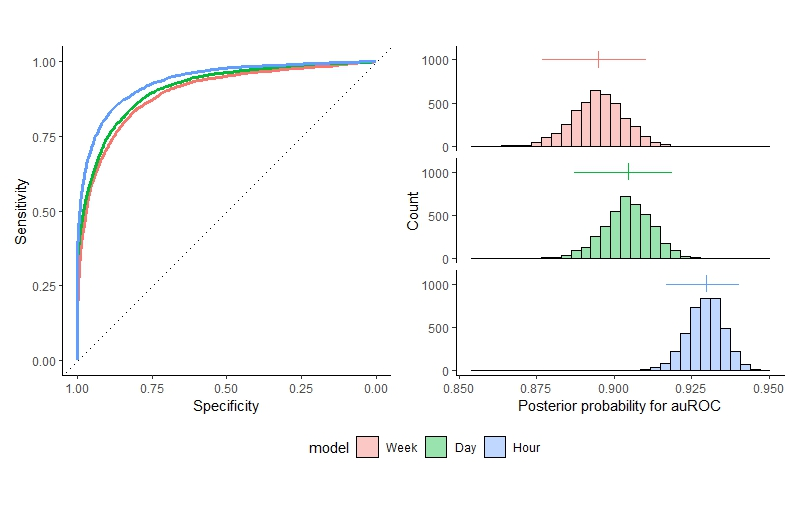
<figcaption>Figure 1: ROC curves and posterior probabilities for auROCs by prediction window. The left panel depicts the aggregate receiver operating characteristic (ROC) curve for each model, derived by concatenating predicted lapse probabilities across all test sets. The dotted line represents the expected ROC curve for a random classifier. The histograms on the right depict the posterior probability distribution for the areas under the receiver operating characteristic curves (auROCs) for each model. The vertical lines represent the median posterior probability and the horizontal line represents the boundaries 95% CI.</figcaption>
</figure>

#### 2.3.3.3 Bayesian Comparisons of Baseline vs. Full Models

We used the posterior probability distributions for the auROCs to formally compare the baseline vs. full models (matched for prediction window). The median increase in auROC for the full vs. baseline week model was 0.097 (95% CI=\[0.082-0.114\], yielding a probability of 1.000 that the full week model had superior performance. The median increase in auROC for the full vs. baseline day model was 0.119 (95% CI=\[0.103-0.137\], yielding a probability of 1.000 that the full day model had superior performance. The median increase in auROC for the full vs. baseline hour model was 0.149 (95% CI=\[0.131-0.170\], yielding a probability of 1.000 that the full hour model had superior performance.

#### 2.3.3.4 Bayesian Comparisons of Full Models by Prediction Window

We also used the posterior probability distributions for the auROCs for the three full models to formally compare the differences in performance by prediction window width. The median increase in auROC for the hour vs. the day model was 0.025 (95% CI=\[0.017-0.035\], yielding a probability of 1.000 that the hour (vs. day) model had superior performance. The median increase in auROC for the hour vs. the week model was 0.035 (95% CI=\[0.025-0.045\], yielding a probability of 1.000 that the hour model (vs. week) had superior performance. The median increase in auROC for the day vs. the week model was 0.010 (95% CI=\[0.000-0.019\], yielding a probability of 0.975 that the day (vs. week) model had superior performance.

#### 2.3.3.5 Other Performance Metrics for the Full Models

<a href="#fig-preds" class="quarto-xref">Figure 10</a> in the Appendix displays histograms for the predicted probabilities of lapse for all observations in the 30 *test sets* separately by prediction window and true outcome for the full models. We evaluated the sensitivity, specificity, balanced accuracy, PPV, and NPV when these predicted lapse probabilities were used for binary classification (*lapse* vs. *no lapse*) with decision thresholds identified by Youden’s Index. All three full models had high sensitivity, specificity, balanced accuracy, and NPV (<a href="#tbl-perf-ema" class="quarto-xref">Table 2</a>). PPV, however, notably declined as the prediction window width decreased.

``` python
table_perf |> 
  knitr::kable()
```

| Metric                    |      Week |       Day |      Hour |
|:--------------------------|----------:|----------:|----------:|
| auROC                     | 0.8906310 | 0.8989930 | 0.9293432 |
| sensitivity               | 0.8232301 | 0.8275224 | 0.8636420 |
| specificity               | 0.8192581 | 0.8454889 | 0.8813554 |
| balanced accuracy         | 0.8275871 | 0.8345976 | 0.8536644 |
| positive predictive value | 0.6301088 | 0.2997223 | 0.0254053 |
| negative predictive value | 0.9435759 | 0.9877148 | 0.9994361 |

Table 2: Performance Metrics for Full models by Prediction Window

PPV can be increased by increasing the decision threshold; however, increasing the decision threshold will also lower the model’s sensitivity. To evaluate the trade-off between PPV (i.e., precision) and sensitivity (i.e., recall) across decision thresholds, we created Precision-Recall curves by concatenating predicted lapse probabilities across the 30 test sets (<a href="#fig-2-ema" class="quarto-xref">Figure 2</a>). For example, the dotted lines in <a href="#fig-2-ema" class="quarto-xref">Figure 2</a> depict the sensitivities (0.718, 0.473, and 0.327 for week, day, and hour models, respectively) associated with decision thresholds that yield 0.700 PPV for each model.

``` python
knitr::include_graphics(path = here::here("figures/ema_2.jpeg"))
```

<figure id="fig-2-ema">
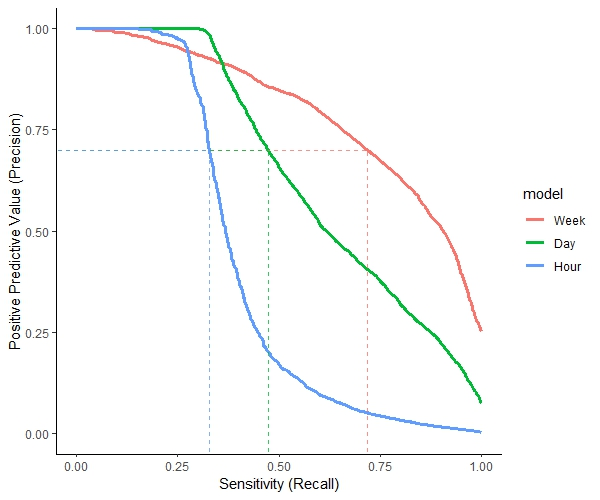
<figcaption>Figure 2: Precision-recall Curves by Prediction Window for the Full Models. The plot depicts the aggregate precision-recall curves for each full model, derived by concatenating predicted lapse probabilities across all test sets. The dotted lines depict the sensitivities (0.718, 0.473, and 0.327 for week, day, and hour models, respectively) associated with decision thresholds that yield 0.700 positive predictive value for each of those models.</figcaption>
</figure>

### 2.3.4 Feature Importance for Full Models

Global importance (mean \|Shapley value\|) for feature categories for each full model appears in Panel A of <a href="#fig-3-ema" class="quarto-xref">Figure 3</a>. Past use was the most important feature category for lapse prediction across prediction window widths. Future abstinence efficacy was also globally important across window widths. Time-varying constructs (craving, time of day) appear to have more impact in lapse prediction for the hour model compared to the day and week models.

Sina plots of local Shapley values (i.e., the influence of feature categories on individual observations) for each model show that some feature categories (e.g., past pleasant events, future stressful events) impact lapse probability for specific individuals at specific times even if they are not globally important across all observations (<a href="#fig-3-ema" class="quarto-xref">Figure 3</a>, Panels B-D).

``` python
knitr::include_graphics(path = here::here("figures/ema_3.jpeg"))
```

<figure id="fig-3-ema">
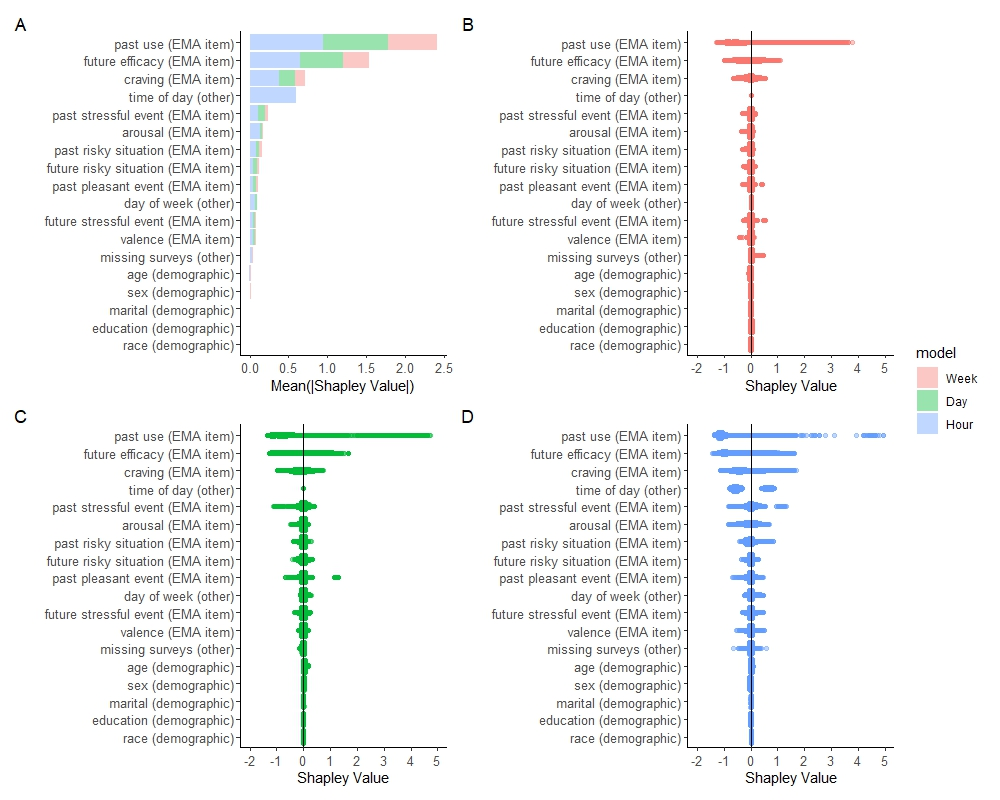
<figcaption>Figure 3: Feature importance (Shapley values) for Full Models by Prediction Window. Panel A displays the global importance (mean |Shapley value|) for feature categories for each full model. Raw EMA features are grouped into categories by the original question from the EMA. Features based on the rates of previous lapses and previous missing surveys, as well as demographics, and the time of day and day of the week for the start of the prediction window are also included. Feature categories are ordered by their aggregate global importance (i.e., total bar length) across the three models. The importance of each feature category for specific models is displayed separately by color. Panels B-D display local Shapley values that quantify the influence of feature categories on individual observations (i.e., a single prediction window for a specific participant) for each model.</figcaption>
</figure>

## 2.4 Discussion

### 2.4.1 Model Performance

All baseline models, which used only past frequency of lapses to predict future lapses, performed moderately well with auROCs in the upper .70s. These results confirm what we would expect: past behavior is a relatively good predictor of future behavior. However, there was still substantial room for increased predictive performance. Furthermore, these baseline models do not identify specific risk factors contributing to lapse predictions at any moment in time for each participant.

All three full models performed exceptionally well, yielding auROCs of 0.89, 0.90, and 0.93 for week, day, and hour level models, respectively. auROCs above .9 are generally described as having “excellent” performance; the model will correctly assign a higher probability to a positive case (e.g., lapse) than a negative case 90% of the time ([Mandrekar, 2010](#ref-mandrekarReceiverOperatingCharacteristic2010)). Bayesian comparisons indicated that these full models performed better than the baseline models for the same prediction window. This confirms that EMA can predict future alcohol lapses in the next week, next day, and next hour with high sensitivity and specificity for new individuals. And, as we describe later, using features that map onto important relapse prevention risk constructs may illuminate momentary contributors to predicted lapses.

This study addressed several important limitations of previous research to advance toward robust sensing and prediction models that can be embedded within digital therapeutics. First, our models were trained on a relatively large, treatment-seeking sample of adults in early recovery from AUD that closely matches the individuals most likely to benefit from such models within a digital therapeutic. Second, we explicitly predicted episodes of goal-inconsistent alcohol use (i.e., lapses) because features that predict goal-inconsistent use likely differ from those that predict other types of alcohol use. Third, we measured EMA features and alcohol use with sufficient frequency and granularity to train well-performing models with high temporal resolution - specifically, hour-by-hour predicted probabilities for lapses in the next week, day, and hour. Fourth, we collected features and outcomes over three months during a high risk period (initial remission ([Hagman et al., 2022](#ref-hagmanDefiningRecoveryAlcohol2022)) from AUD). Fifth, we used cutting-edge resampling methods (grouped, nested, k-fold cross-validation) to provide valid estimates of how our models would perform with new individuals. Finally, we used interpretable machine learning methods (SHAP ([Lundberg & Lee, 2017](#ref-lundbergUnifiedApproachInterpreting2017); [Molnar, 2022](#ref-molnarInterpretableMachineLearning2022))) to better understand how our models made predictions globally and locally for specific participants at discrete moments in time.

### 2.4.2 Understanding & Contextualizing Model Performance

We used SHAP to describe the relative importance of key relapse prevention model constructs (represented by categories of features) to predicted lapses in our three full models. Some constructs consistently emerged as globally important across week, day, and hour level models. Unsurprisingly, the largest contribution to lapse prediction was past use. This is consistent with decades of research on relapse precipitants and our understanding of human behavior more generally (i.e., past behavior predicts future behavior) ([Marlatt & Gordon, 1985](#ref-marlattRelapsePreventionMaintenance1985)). Decreases in abstinence self-efficacy were also strongly associated with increased probability of future lapses across windows.

The relative importance of some constructs descriptively differed by window width. Punctate, time-varying constructs (e.g., craving, arousal, recent risky situation) had greater impact on predicted lapse probabilities in the hour model compared to day or week models. The time of day feature was relatively important (top four) in the hour model, such that lapses were more likely for hour-level prediction windows that began in the evenings. The day of week feature made a small contribution to the hour and day models given that lapses were more likely on weekends. The time and day features were not useful in the week model because its associated prediction window (a full week) spanned all days and times, making the time and day that the window began irrelevant. The increased global importance for all these punctate features/constructs to immediate lapse risk likely contributed to the hour model outperforming the day and week models. These important global differences in next hour lapse risk also highlight the need for just-in-time interventions that can address these imminent but short-lived risks.

The individual, local Shapley values also shed light on the multidimensional and heterogeneous nature of lapse risk in our sample. Sina plots of local Shapley values (<a href="#fig-3-ema" class="quarto-xref">Figure 3</a>) display meaningful ranges of scores for most feature categories. This means that even feature categories with lower global importance (e.g., past pleasant events, future stressful events) still consequentially impacted predictions for some individuals at specific times. This variability in locally important features highlights the potential benefits of recommending optimal interventions and other supports that are personalized for that person at that moment in time.

Our demographic features did not display high global or local importance. Despite the diversity in sex, age, education, and marital status in our sample, these features did not meaningfully contribute to lapse prediction. Although this does not preclude these features’ predictive utility, it does suggest that other EMA feature categories may be more relevant for lapse prediction than these characteristics. Race/ethnicity also did not emerge as globally or locally important features. However, the limited representation of participants of color in our sample warrants caution in drawing conclusions about the predictive utility of race and ethnicity at this time.

### 2.4.3 Considerations for Clinical Implementation

#### 2.4.3.1 Smart Digital Therapeutics

We believe these full models may be most effective when embedded in a “smart” digital therapeutic that guides patients toward optimal, adaptive engagement to address their ongoing and momentary risks. These models can provide the patient’s predicted future lapse probability and the features that meaningfully contribute to that probability. We consciously selected EMA items that map onto well-known risk factors from the relapse prevention literature. Consequently, these outputs can be used to recommend specific intervention and support modules that are risk-relevant for each patient - much like a clinician would do if they were available in-the-moment. For example, during sensed periods of high stress, stress reduction techniques (e.g., guided mindfulness) could be recommended. If increased time with risky people or locations is driving lapse risk, the digital therapeutic can support patients to attend support meetings, or encourage participation in the in-app discussion board.

Module recommendations can also be tuned more precisely using the patient’s current lapse probability. If increased craving yields a high predicted lapse probability, stimulus control modules would be recommended (e.g., remove drinking cues, leave unsafe environment). Conversely, if craving is detected but lapse probability is lower, urge management modules that permit coping with the craving in-place could be recommended (e.g., urge surfing, distracting activities/games).

Of course, we must first determine how best to provide module recommendations such that patients trust and follow the recommendation. Increasing the interpretability and transparency of otherwise “black box” machine learning prediction models can improve perceptions, but providing complex or unnecessary information may instead undermine trust ([Molnar, 2022](#ref-molnarInterpretableMachineLearning2022)). Additional research using appropriate research designs is needed to optimize recommendation messaging to increase adherence and clinical outcomes ([Collins, 2018](#ref-collinsOptimizationBehavioralBiobehavioral2018)).

A smart digital therapeutic can potentially improve clinical outcomes in multiple ways. First, feedback from the prediction model could improve patient insight and self-monitoring by connecting their daily experiences to changing risk. Second, it can remove patient uncertainty by guiding selection from the substantial content available. Third, a smart digital therapeutic could encourage risk-relevant engagement. Rather than trying to increase overall time using the digital therapeutic, patients could be guided to use the supports that specifically target their personal risk factors at that moment in time. Thus, smart digital therapeutics are well-positioned to pursue the precision mental health goal to “provide the right treatment to the right patient at the right time, every time” ([Kaiser, 2015](#ref-kaiserObamaGivesEast2015)).

#### 2.4.3.2 Categorical Lapse Predictions

Our models natively provide quantitative predictions of lapse probabilities. These lapse probabilities can also be used to make categorical predictions (lapse vs. no-lapse) by applying a decision threshold to the quantitative predicted lapse probabilities (i.e., predict lapse when the probability exceeds the decision threshold).

We observed high sensitivity and specificity for these categorical predictions at a decision threshold selected to balance these two performance metrics. However, the PPV (proportion of predicted lapses that were true lapses) of these categorical predictions in our full models was moderate to very low at this threshold (ranging from .630 down to .025 across window widths). For this reason, categorical predictions should be provided to patients with extreme caution, if at all. Instead, we favor the quantitative lapse probabilities as risk indicators to guide intervention and support recommendations.

If categorical predictions are necessary, PPV can be improved by raising the decision threshold, but this comes at the cost of reduced sensitivity. We explored this trade-off in the precision-recall curves displayed in <a href="#fig-2-ema" class="quarto-xref">Figure 2</a>. From these curves, it is clear decision thresholds that yield higher PPV (e.g., .700) exist for all three full models, but the associated sensitivity will be lower (e.g., 0.718, 0.473, and 0.327 for the week, day, and hour models, respectively, at this threshold). Clinical implementation of categorical predictions will require selecting an optimal decision threshold after weighing the cost of missing true lapses (low sensitivity) vs. predicting lapses that subsequently do not occur (low PPV). Different thresholds could be used depending on the purpose, context, available resources, or even patient preference.

### 2.4.4 Additional Limitations and Future Directions

Successful clinical implementation of our models will require several important steps to address limitations in our work to-date. First, we need to enrich the training data to include diversity across race, ethnicity, and geographic region. Our current prediction models may not work well for people of color or people from rural communities. Prediction models must use diverse training samples to avoid exacerbating rather than mitigating existing disparities. We must also collect data from individuals in later stages of recovery beyond initial remission; features that predict lapses may differ in these later periods. We are intentionally addressing these issues in a current NIH protocol that recruits nationally for demographic and geographic diversity and follows participants for up to 1.5 years into their recovery ([Moshontz et al., 2021](#ref-moshontzProspectivePredictionLapses2021)).

The chronic nature of AUD may require sustained use of a sensing and prediction system. Consequently, the burden of using such systems must be considered. Participants with AUD find three months of 4x daily EMA to be generally acceptable and report that they could hypothetically sustain this for at least a year if there were clinical benefits to them ([Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023)). They also report that 1x daily EMA may be more feasible still ([Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023)). We plan to develop future prediction models that use only the single morning EMA to contrast the assessment burden vs. model performance trade-off between our current models and putatively lower burden models. We also plan to train models that use features based on passively sensed geolocation and cellular communications data-streams (i.e., meta-data from calls and text messages; text message content) that were also collected from our participants. These passively sensed signals may be sufficient as inputs to an exceptionally low burden prediction model. Alternatively, they can be added to models that also include EMA to increase model performance further and/or to reduce the frequency or length of the EMA surveys while maintaining comparable performance.

Our current models predict probability of imminent lapses. The hour and day full models are well-positioned to identify and recommend just-in-time interventions to address these immediate risks. However, the week model may not have sufficient temporal specificity to recommend immediate patient action. Instead, its clinical utility may improve if we shift this coarser window width into the future. For example, we could train a model to predict the probability of lapse at any point during a week window that begins two weeks in the future. This “time-lagged” model could provide patients with increased lead time to implement supports that might not be immediately available to them (e.g., schedule therapy appointment, request support from an AA sponsor).

Finally, XGBoost does not take advantage of grouping observations within participants or systematic variation unique to individual participants[3]. Independence of observations is not necessary for statistically valid prediction. When observations are grouped/repeated within participants, linear mixed effects models or other statistical models that can estimate both population-level (fixed) effects and participant-level (random) effects may predict better for the participants on which they were trained than would XGBoost. However, we are not interested in making predictions for participants in our training set. We want to know how well our models will work with new individuals like those that will use smart digital therapeutics in the future.

In some domains, there has been increasing interest in idiographic approaches where models are trained and then implemented for the same individual([Fisher et al., 2019](#ref-fisherOpenTrialPersonalized2019); [Wright & Zimmermann, 2019](#ref-wrightAppliedAmbulatoryAssessment2019)). Such approaches may also yield superior predictive performance but are not possible to implement for outcomes like alcohol use lapse. A person-specific lapse prediction model requires a sufficient number of positive labels (i.e., lapses) for that individual. It may be too late to prevent relapse if we must wait until an individual has lapsed multiple (perhaps many) times to offer help. We believe the most promising approaches may involve first developing population-based models and updating these models with person-specific information as the patient uses the system ([Zhou et al., 2018](#ref-zhouEvaluatingMachineLearning2018)). We are pursuing these cutting-edge models as a near-term future direction.

In this study, we have demonstrated that sensing and prediction systems can now be developed to predict future lapses with high temporal resolution. Important steps still remain before these systems can be embedded within smart digital therapeutics and delivered to patients. However, the necessary steps are clear and, when completed, these smart digital therapeutics hold promise to advance us toward precision mental health solutions that may reduce both barriers and disparities in AUD treatment.

# 3. Lagged Predictions of Next Week Alcohol Use for Precision Mental Health Support

## 3.1 Introduction

### 3.1.1 Precision Medicine

Substance use disorders are chronic diseases, characterized by high relapse rates, frequent reentry into treatment, and an increased risk of mortality ([Dennis & Scott, 2007](#ref-dennisManagingAddictionChronic2007)). Few individuals receive any treatment, and even fewer receive continuous care throughout their recovery ([SAMHSA Center for Behavioral Health Statistics and Quality, 2021](#ref-samhsacenterforbehavioralhealthstatisticsandquality2021NSDUHDetailed2021)). Continuing care, including ongoing monitoring and early re-intervention, has been well established as the gold standard for managing chronic health conditions such as diabetes, asthma, and HIV. Yet, continuing care for substance use disorders is largely lacking ([Socías et al., 2016](#ref-sociasAdoptingCascadeCare2016); [Stanojlović & Davidson, 2021](#ref-stanojlovicTargetingBarriersSubstance2021)).

Importantly, people need different types of support at different points in their recovery. Personalized monitoring of changes in relapse risk factors could help patients adapt their lifestyle, behaviors, and supports to successfully address these factors ([Friedmann et al., 2004](#ref-friedmannEffectMatchingComprehensive2004); [Kranzler & McKay, 2012](#ref-kranzlerPersonalizedTreatmentAlcohol2012)). A precision medicine approach to automated continuous relapse risk monitoring and recovery support could help fill this gap in continuing care.

Precision medicine has been a goal in healthcare for over half a century ([DeRubeis, 2019](#ref-derubeisHistoryCurrentStatus2019)). Traditionally, it seeks to answer the question of *how* to best treat a specific individual, given their unique combination of genetic, lifestyle, and environmental characteristics (e.g., which medication is most effective for whom).

Today, this approach extends to mental health conditions (i.e., precision mental health) such as depression, substance use disorders, and suicide. Mental health conditions are complex, fluctuating processes. Many medical conditions often have clear biological precursors, that can be treated well with a single medication. In contrast, mental health conditions are influenced by numerous psychosocial factors, and require a wide array of support options. Moreover, the factors driving mental health conditions differ between individuals and can change within an individual over time. Thus, precision mental health must consider both the *how* and the *when* (e.g., which treatment is most effective for whom at what moment).

### 3.1.2 Previous Work

In early example of precision mental health applied to substance use disorders, the Project MATCH research group attempted to match individuals with alcohol use disorder to their optimal treatment based on baseline measures of individual characteristics ([Project Match Research Group, 1997](#ref-projectmatchresearchgroupMatchingAlcoholismTreatments1997)). Unfortunately, early studies like these were methodologically constrained to use small sets of features (i.e., individual trait and demographic differences) that failed to capture the complex and heterogeneous nature of substance use disorders and use a single measurement point (i.e., at baseline) to predict a non-linear, time-varying course of recovery, lapse, and relapse ([Witkiewitz & Marlatt, 2007](#ref-witkiewitzModelingComplexityPosttreatment2007)).

Recent advances in both machine learning and personal sensing may address these barriers to successful precision mental health. Machine learning can handle large sets of features and non-linear and interactive relationships between these features. As a result models better represent the nuanced complexity of mental health conditions. Moreover, machine learning tools can help understand which factors are important to a specific individual at a specific moment in time, addressing the question of *how*.

Personal sensing allows for frequent, longitudinal measurement of changes in proximal risk (e.g., for a lapse) with high temporal precision, for better understanding the *when*. This precision is particularly important for predicting discrete symptoms or behaviors. It would be unreasonable to expect that we could predict a lapse with any temporal precision using only demographic and baseline characteristics that become more distal as time progresses. Rather, lapse prediction requires dense, long-term monitoring of symptoms and related states proximal to the outcome. Ecological momentary assessment (EMA) may be particularly well-suited for risk prediction algorithms. It offers momentary subjective insight into constructs that can be easily mapped onto modular forms of treatment, such as the relapse prevention model ([Marlatt & Gordon, 1985](#ref-marlattRelapsePreventionMaintenance1985); [Witkiewitz & Marlatt, 2004](#ref-witkiewitzRelapsePreventionAlcohol2004)). EMA also appears to be well tolerated by individuals with substance use disorders ([Moshontz et al., 2021](#ref-moshontzProspectivePredictionLapses2021); [Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023)). Thus, it can serve as an important signal for predicting substance use outcomes and interpreting clinically relevant features over a sustained period.

Promising preliminary work suggests it is possible to build EMA models that predict immediate lapses back to substance use ([Bae et al., 2018](#ref-baeMobilePhoneSensors2018); [Chih et al., 2014](#ref-chihPredictiveModelingAddiction2014); [Soyster et al., 2022](#ref-soysterPooledPersonspecificMachine2022); [Walters et al., 2021](#ref-waltersUsingMachineLearning2021)). In a previous study from our group, we demonstrated that we can do this very well ([Wyant et al., 2024](#ref-wyantMachineLearningModels2023)). We used 4X daily EMA with questions designed to measure theoretically-implicated risk factors including past use, craving, past pleasant events, past and future risky situations, past and future stressful events, emotional valence and arousal, and self-efficacy. We used all available data up until a moment in time to predict the probability of an alcohol lapse in the next week, day, and hour.

Narrow prediction window widths (i.e., next hour or next day) are well suited for addressing immediate risk. These models can be dynamically updated (i.e., at least daily) to provide individuals information about changes in their risk and make supportive recommendations based on the top features contributing to their risk. For example, recommending a coping with craving activity when someone has increased craving, or recommending a guided relaxation video when someone is reporting recent stressful events. Importantly, this assumes that the recommendations can be implemented immediately.

However, many appropriate support recommendations take time to set up, and are not available in the moment (e.g., attending a self-help meeting, planning an outing with important people in their life, or scheduling an appointment with a therapist). In these cases, patients would benefit from advanced warning about changes in their risk.

While our next week model may be less helpful for addressing immediate risk, as a lapse can occur at any point in the week window (i.e., immediately up until one week from now). It may be preferred for as a *time-lagged* model where prediction windows are shifted further into the future (i.e., away from the moment in time the model is updated) to provide patients with increased lead time to implement supports not immediately available to them. A wider prediction window width (i.e, one week) will yield higher proportions of positive labels mitigating issues of an unbalanced outcome. Additionally, when scheduling real world support, it is important that the lead up time is adequate and not that the prediction is necessarily temporally precise.

### 3.1.3 Current Study

In this study, we evaluated the performance of a model predicting immediate next week lapses compared to models using increased lag time between the prediction time points and the start of the prediction window. Specifically, we used the same EMA features as our immediate model and trained new models to predict the probability of a lapse beginning one day (24 hours), three days (72 hours), one week (168 hours), or two weeks (336 hours) into the future. We evaluated each lagged model to determine if they perform at clinically implementable levels and assessed the relative difference in performance as lag time increased.

It is also important to look beyond overall model performance. Models that work for only a subset of people, if implemented, could widen existing treatment disparities. Therefore we reported our models’ performance for three dichotomized demographic groups with known disparities in access to substance use treatment - race and ethnicity (not White vs. non-Hispanic White) ([Kilaru et al., 2020](#ref-kilaruIncidenceTreatmentOpioid2020); [Pinedo, 2019](#ref-pinedoCurrentReexaminationRacial2019)), income (below poverty vs. above poverty) ([Olfson et al., 2022](#ref-olfsonHealthcareCoverageService2022)), and sex at birth (female vs. male) ([Greenfield et al., 2007](#ref-greenfieldSubstanceAbuseTreatment2007); [Kilaru et al., 2020](#ref-kilaruIncidenceTreatmentOpioid2020)).

## 3.2 Methods

### 3.2.1 Transparency and Openness

We adhere to research transparency principles that are crucial for robust and replicable science. We preregistered our data analytic strategy. We reported how we determined the sample size, all data exclusions, all manipulations, and all study measures. Finally, our data, analysis scripts, annotated results, questionnaires, and other study materials are publicly available (<https://osf.io/xta67/>).

### 3.2.2 Participants

We recruited participants in early recovery (1-8 weeks of abstinence) from moderate to severe alcohol use disorder in Madison, Wisconsin, US for a three month longitudinal study. One hundred fifty one participants were included in our analyses. We used data from all participants included in our previous study (see ([Wyant et al., 2024](#ref-wyantMachineLearningModels2023)) for enrollment and disposition information). This sample size was determined based on traditional power analysis methods for logistic regression ([Hsieh, 1989](#ref-hsiehSampleSizeTables1989)) because comparable approaches for machine learning models have not yet been validated. Participants were recruited through print and targeted digital advertisements and partnerships with treatment centers. We required that participants:

1.  were age 18 or older,
2.  could write and read in English,
3.  had at least moderate AUD (\>= 4 self-reported DSM-5 symptoms),
4.  were abstinent from alcohol for 1-8 weeks, and
5.  were willing to use a single smartphone (personal or study provided) while on study.

We also excluded participants exhibiting severe symptoms of psychosis or paranoia.

### 3.2.3 Procedure

Participants completed five study visits over approximately three months. After an initial phone screen, participants attended an in-person screening visit to determine eligibility, complete informed consent, and collect self-report measures. Eligible, consented participants returned approximately one week later for an intake visit. Three additional follow-up visits occurred about every 30 days that participants remained on study. Participants were expected to complete four daily EMAs while on study. Other personal sensing data streams (geolocation, cellular communications, sleep quality, and audio check-ins) were collected as part of the parent grant’s aims (R01 AA024391). Participants could earn up to \$150/month if they completed all study visits, had 10% or less missing EMA data and opted in to provide data for other personal sensing data streams.

### 3.2.4 Measures

#### 3.2.4.1 Ecological Momentary Assessments

Participants completed four brief (7-10 questions) EMAs daily. The first and last EMAs of the day were scheduled within one hour of participants’ typical wake and sleep times. The other two EMAs were scheduled randomly within the first and second halves of their typical day, with at least one hour between EMAs. Participants learned how to complete the EMA and the meaning of each question during their intake visit.

On all EMAs, participants reported dates/times of any unreported past alcohol use. Next, participants rated the maximum intensity of recent (i.e., since last EMA) experiences of craving, risky situations, stressful events, and pleasant events. Finally, participants rated their current affect on two bipolar scales: valence (Unpleasant/Unhappy to Pleasant/Happy) and arousal (Calm/Sleepy to Aroused/Alert).

On the first EMA each day, participants also rated the likelihood of encountering risky situations and stressful events in the next week and the likelihood that they would drink alcohol in the next week (i.e., abstinence self-efficacy).

#### 3.2.4.2 Individual Characteristics

We collected self-report information about demographics (age, sex, race, ethnicity, education, marital status, employment, and income) and AUD symptom count to characterize our sample. Demographic information was also included as features in our models and a subset (sex, race, ethnicity, and income) used for model fairness analyses.

As part of the aims of the parent project we collected many other trait and state measures throughout the study. A complete list of all measures can be found on our study’s OSF page.

### 3.2.5 Data Analytic Strategy

Data preprocessing, modeling, and Bayesian analyses were done in R using the tidymodels ecosystem ([Goodrich et al., 2023](#ref-goodrichRstanarmBayesianApplied2023); [Kuhn, 2022](#ref-kuhnTidyposteriorBayesianAnalysis2022); [Kuhn & Wickham, 2020](#ref-kuhnTidymodelsCollectionPackages2020)). Models were trained and evaluated using high-throughput computing resources provided by the University of Wisconsin Center for High Throughput Computing ([Center for High Throughput Computing, 2006](#ref-chtc)).

#### 3.2.5.1 Predictions

A *prediction time point* is the hour at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction time point (i.e., the scoring epoch) was used to generate these predictions (see Feature Engineering section). Prediction time points were updated hourly (<a href="#fig-methods-lag" class="quarto-xref">Figure 4</a>, Panel A). The first prediction time point for each participant was 24 hours from midnight on their study start date. This ensured at least 24 hours of past EMAs for future lapse prediction at these first time points. Subsequent prediction time points for each participant repeatedly rolled hour-by-hour until the end of their study participation.

The *prediction window* is the window of time in which a lapse might occur. The prediction window width for all our models was one week (i.e., models predicted the probability of a lapse occurring within a one week window). Prediction windows rolled forward hour-by-hour with the prediction time point (<a href="#fig-methods-lag" class="quarto-xref">Figure 4</a>, Panel B).

Finally, there were five possible *lag times* between the prediction time point and start of the prediction window. A prediction window either started immediately after the prediction time point (0 lag) or was lagged by 24, 72, 168, or 336 hours (<a href="#fig-methods-lag" class="quarto-xref">Figure 4</a>, Panel B).

Therefore, our models provided hour-by-hour probabilities of an alcohol lapse in the next week pushed out up to two weeks into the future. For example, for a participant on their 30th day on study, the model would use all 30 days of data and make predictions for 5 different lags.

``` python
knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)
```

<figure id="fig-methods-lag">
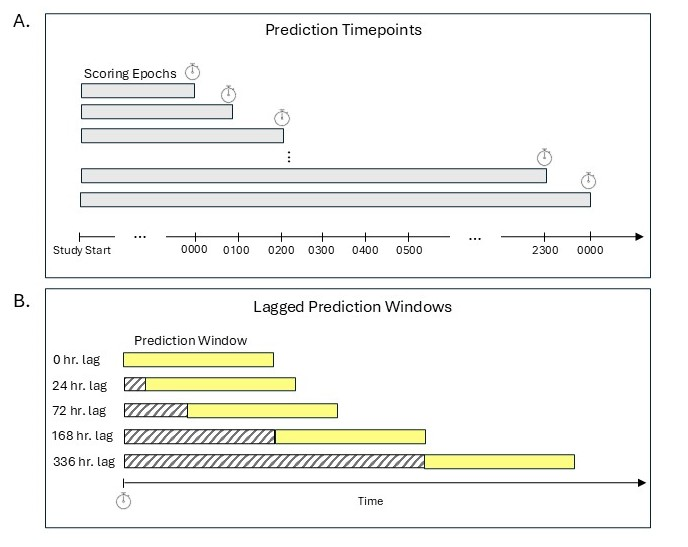
<figcaption>Figure 4: Panel A shows the prediction time points at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction time point was used to generate these predictions. Features were created for varying scoring epochs before the prediction time point (i.e., 12, 24, 48, 72, and 168 hours). Prediction time points were updated hourly. Panel B shows how the prediction window (i.e., window of time in which a lapse might occur) rolls forward hour-by-hour with the prediction time point with the prediction time point. The prediction window width for all our models was one week (i.e., models predicted the probability of a lapse occurring within a one week window). Additionally, there were five possible lag times between the prediction time point and start of the prediction window. A prediction window either started immediately after the prediction time point (0 lag) or was lagged by 24, 72, 168, or 336 hours.</figcaption>
</figure>

#### 3.2.5.2 Labels

The start and end date/time of past drinking episodes were reported on the first EMA item. A prediction window was labeled *lapse* if the start date/hour of any drinking episode fell within that window. A window was labeled *no lapse* if no alcohol use occurred within that window +/- 24 hours. If no alcohol use occurred within the window but did occur within 24 hours of the start or end of the window, the window was excluded.

We ended up with a total of 270,081 labels for our baseline (no lag) model, 266,599 labels for our 24 hour lagged model, 259,643 labels for our 72 hour lagged model, 245,707 labels for our 168 hour lagged model, and 221,206 labels for our 336 hour lagged model.

#### 3.2.5.3 Feature Engineering

Features were calculated using only data collected before each prediction time point to ensure our models were making true future predictions. For our no lag models the prediction time point was at the start of prediction window, so all data prior to the start of the prediction window was included. For our lagged models, the prediction time point was 24, 72, 168, or 336 hours prior to the start of the prediction window, so the last EMA data used for feature engineering were collected 24, 72, 168, or 336 hours prior to the start of the prediction window.

A total of 279 features were derived from two data sources:

1.  *Demographics*: We created quantitative features for age and personal income, and dummy-coded features for sex, race/ethnicity, marital status, education, and employment.

2.  *Previous EMA responses*: We created raw EMA and change features for varying scoring epochs (i.e., 12, 24, 48, 72, and 168 hours) before the prediction time point for all EMA items. Raw features included min, max, and median scores for each EMA item across all EMAs in each epoch for that participant. We calculated change features by subtracting the participants’ overall mean score for each EMA item (using all EMAs collected before the start of the prediction window) from the associated raw feature. We also created raw and change features based on the most recent response for each EMA question and raw and change rate features from previously reported lapses and number of completed EMAs.

Other generic feature engineering steps included imputing missing data (median imputation for numeric features, mode imputation for nominal features) and removing zero and near-zero variance features as determined from held-in data (see Cross-validation section below).

#### 3.2.5.4 Model Training and Evaluation

##### 3.2.5.4.1 Model Configurations

We trained and evaluated five separate classification models: one baseline (no lag) model and one model for 24 hour, 72 hour, 168 hour, and 336 hour lagged predictions. We considered four well-established statistical algorithms (elastic net, XGBoost, regularized discriminant analysis, and single layer neural networks) that vary across characteristics expected to affect model performance (e.g., flexibility, complexity, handling higher-order interactions natively) ([Kuhn & Johnson, 2018](#ref-kuhnAppliedPredictiveModeling2018)).

Candidate model configurations differed across sensible values for key hyperparameters. They also differed on outcome resampling method (i.e., no resampling and up-sampling and down-sampling of the outcome using majority/no lapse to minority/lapse ratios ranging from 1:1 to 2:1). We calibrated predicted probabilities using the beta distribution to support optimal decision-making under variable outcome distributions ([Kull et al., 2017](#ref-kullSigmoidsHowObtain2017)).

##### 3.2.5.4.2 Cross-validation

We used participant-grouped, nested cross-validation for model training, selection, and evaluation with auROC. auROC indexes the probability that the model will predict a higher score for a randomly selected positive case (lapse) relative to a randomly selected negative case (no lapse). Grouped cross-validation assigns all data from a participant as either held-in or held-out to avoid bias introduced when predicting a participant’s data from their own data. We used 1 repeat of 10-fold cross-validation for the inner loops (i.e., *validation* sets) and 3 repeats of 10-fold cross-validation for the outer loop (i.e., *test* sets). Best model configurations were selected using median auROC across the 10 validation sets. Final performance evaluation of those best model configurations used median auROC across the 30 test sets.

##### 3.2.5.4.3 Bayesian Model

We used a Bayesian hierarchical generalized linear model to estimate the posterior probability distributions and 95% Bayesian credible intervals (CIs) from the 30 held-out test sets for our five best models. Following recommendations from the rstanarm team and others ([Gabry & Goodrich, 2023](#ref-gabryPriorDistributionsRstanarm2023); [RStudio Team, 2020](#ref-rstudioteamRStudioIntegratedDevelopment2020)), we used the rstanarm default autoscaled, weakly informative, data-dependent priors that take into account the order of magnitude of the variables to provide some regularization to stabilize computation and avoid over-fitting.[4] We set two random intercepts to account for our resampling method: one for the repeat, and another for the fold nested within repeat. We specified two sets of contrasts for model comparisons. The first set compared each lagged model to the baseline model (0 lag vs. 24 hour lag, 0 lag vs. 72 hour lag, 0 lag vs. 168 lag, 0 lag vs. 336 lag). The second set compared adjacently lagged models (24 hour lag vs. 72 hour lag, 72 hour lag vs. 168 hour lag, 168 hour lag vs. 336 hour lag). auROCs were transformed using the logit function and regressed as a function of model contrast.

From the Bayesian model we obtained the posterior distribution (transformed back from logit) and Bayeisan CIs for all five models. To evaluate our models’ overall performance we report the median posterior probability for auROC and Bayesian CIs. This represents our best estimate for the magnitude of the auROC parameter for each model. If the confidence intervals do not contain .5 (chance performance), this suggests our model is capturing signal in the data.

We then conducted Bayesian model comparisons using our two sets of contrasts - baseline and adjacent lags. For both model comparisons, we determined the probability that the models’ performances differed systematically from each other. We also report the precise posterior probability for the difference in auROCs and the 95% Bayesian CIs. If there was a probability \>.95 that the more lagged model’s performance was worse, we labeled the model contrast as significant.

##### 3.2.5.4.4 Fairness Analyses

We calculated the median posterior probability and 95% Bayesian CI for auROC for each model separately by race and ethnicity (not White vs. non-Hispanic White), income (below poverty vs. above poverty[5]), and sex at birth (female vs. male). We conducted Bayesian group comparisons to assess the likelihood that each model performs differently by group. We report the median difference and range in posterior probabilities across all models. The median auROC and Bayesian CIs are reported separately by group and model in the supplement.[6]

## 3.3 Results

### 3.3.1 Demographic and Lapse Characteristics

This study used the same sample as the previous study. See <a href="#tbl-dem" class="quarto-xref">Table 1</a> in Chapter 2 for a detailed breakdown of the demographic and lapse characteristics of our sample (N = 151).

### 3.3.2 Model Evaluation

Histograms of the full posterior probability distributions for auROC for each model are available in the supplement. The median auROCs from these posterior distributions were 0.892 (baseline), 0.886 (24 hour lag), 0.874 (72 hour lag), 0.869 (168 hour lag), and 0.851 (336 hour lag). These values represent our best estimates for the magnitude of the auROC parameter for each model. The 95% Bayesian CI for the auROCs for these models were relatively narrow and did not contain 0.5: baseline \[0.872-0.910\], 24 hour lag \[0.865-0.905\], 72 hour lag \[0.851-0.894\], 168 hour lag \[0.846-0.891\], 336 hour lag \[0.825-0.874\]. Panel A in <a href="#fig-2-lag" class="quarto-xref">Figure 5</a> displays these median auROCs and 95% Bayesian CIs by model. A description of feature importance by model is available in the supplement.

``` python
fig_2 
```

<figure id="fig-2-lag">
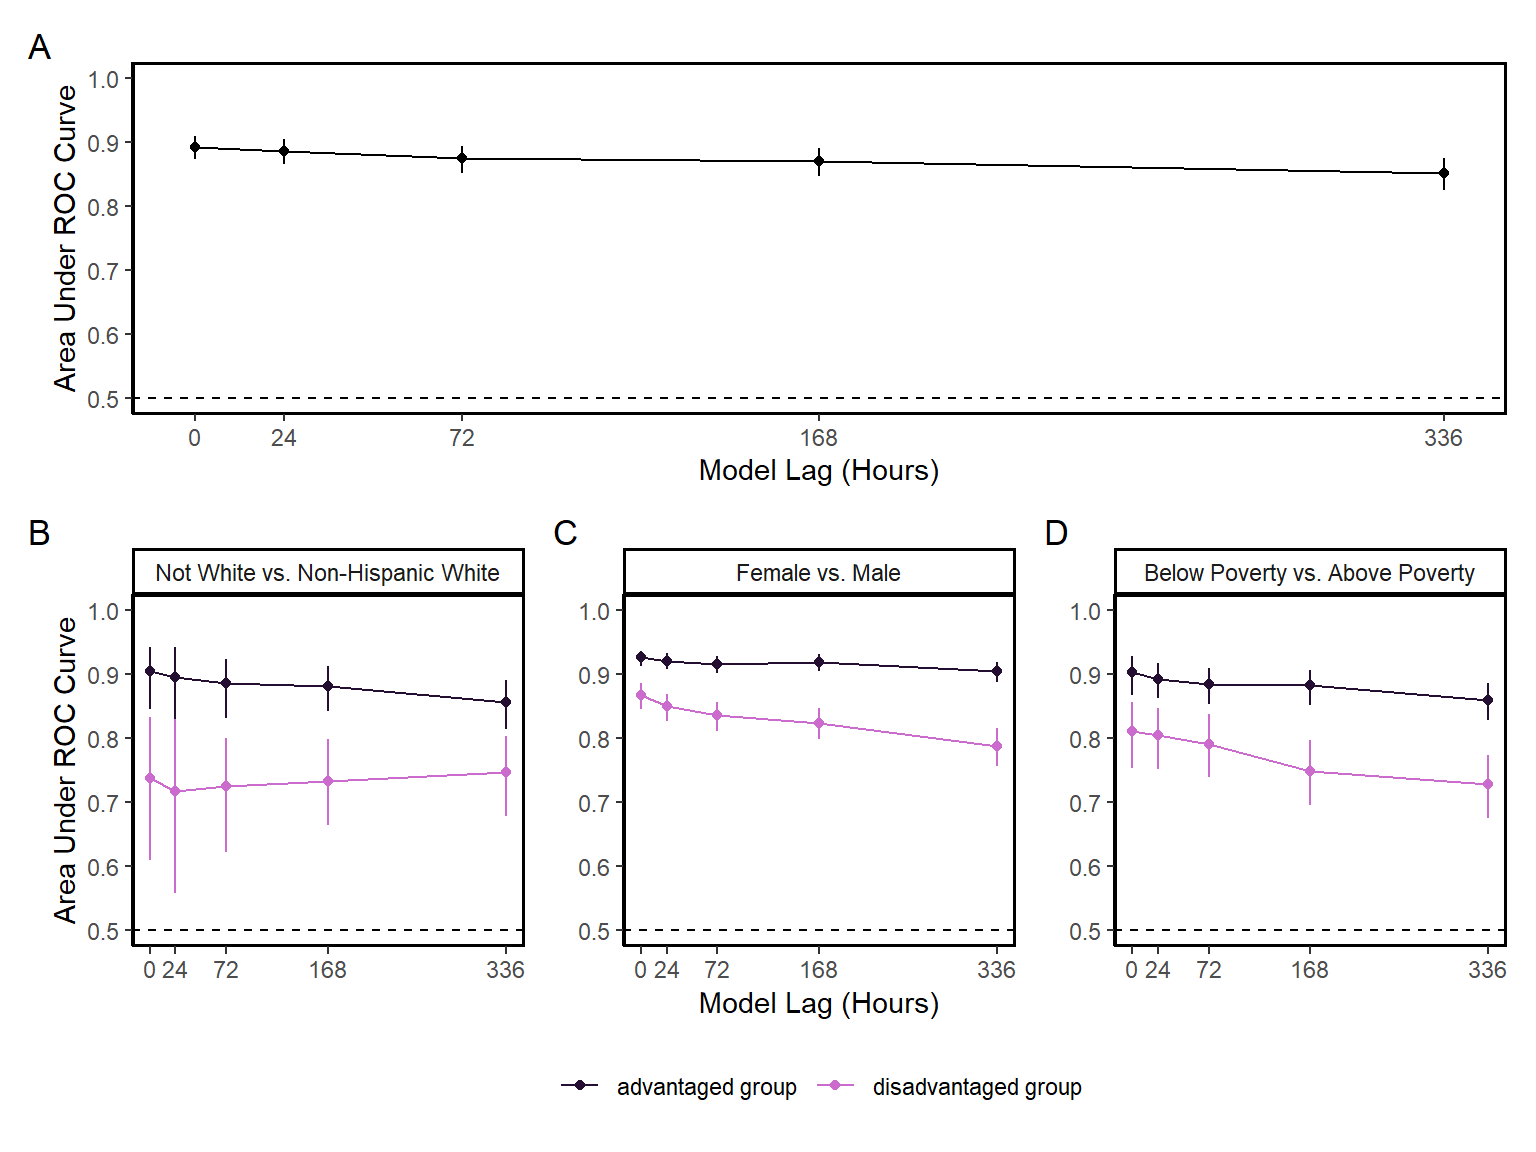
<figcaption>Figure 5: Panel A in displays the median posterior probability for area under ROC curve (auROC) and 95% Bayesian CI for each lagged model (0, 24, 72, 168, 336 hours). Dashed line represents a random classifier with an auROC of .5. Panels B-D display the median auROC and Bayesian credible interval by model and fairness contrast. The darker lines represent the advantaged groups (White, male, above poverty) and the lighter lines represent the disadvantaged groups (not-White, female, below poverty). Dashed line represents a random classifier with an auROC of .5.</figcaption>
</figure>

### 3.3.3 Model Comparisons

<a href="#tbl-contrast-lag" class="quarto-xref">Table 3</a> presents the median difference in auROC, 95% Bayesian CI, and posterior probability that that the auROC difference was greater than 0 for all baseline and adjacent lag contrasts. There was strong evidence (probabilities \> .95) that the lagged models performed worse than the baseline (no lag) model, with average drops in auROC ranging from 0.006-0.041. There was also moderately strong evidence (probabilities \> .86) that the more lagged models performed worse than the previous adjacent lag, with average drops in auROC ranging from 0.004-0.018.

``` python
table_ci |> 
  knitr::kable()
```

| Contrast           | Median | Bayesian CI       | Probability |
|:-------------------|:-------|:------------------|:------------|
| Baseline Contrasts |        |                   |             |
| 0 vs. 24           | 0.006  | \[0, 0.012\]      | 0.956       |
| 0 vs. 72           | 0.018  | \[0.012, 0.025\]  | 1           |
| 0 vs. 168          | 0.023  | \[0.016, 0.029\]  | 1           |
| 0 vs. 336          | 0.041  | \[0.033, 0.05\]   | 1           |
| Adjacent Contrasts |        |                   |             |
| 24 vs. 72          | 0.012  | \[0.006, 0.019\]  | 0.999       |
| 72 vs. 168         | 0.004  | \[-0.002, 0.011\] | 0.862       |
| 168 vs. 336        | 0.018  | \[0.011, 0.026\]  | 1           |

Table 3: Median difference in auROC, 95% Bayesian credible interval (CI), and posterior probability that that the auROC difference was greater than 0 for all baseline and adjacent lag contrasts.

### 3.3.4 Fairness Analyses

Panels B-D in <a href="#fig-2-lag" class="quarto-xref">Figure 5</a> shows the median auROC and credible intervals for each model separately by race (not White; *N* = 20 vs. Non-Hispanic White; *N* = 131), sex at birth (female; *N* = 74 vs. male; *N* = 77), and income (below poverty; *N* = 18 vs. above poverty; *N* = 133). There was strong evidence (probabilities \> .98) that our models performed better for the advantaged groups (White, male, above poverty) compared to the disadvantaged groups (not-White, female, below poverty). On average there was a median decrease in auROC of 0.161 (range 0.108-0.175) for participants who were not White compared to non-Hispanic White participants. On average there was a median decrease in auROC of 0.080 (range 0.058-0.116) for female participants compared to male participants. On average there was a median decrease in auROC of 0.092 (range 0.087-0.133) for participants below the federal poverty line compared to participants above the federal poverty line. We also report the median difference in auROC, 95% Bayesian CI, and posterior probability that that the auROC difference was greater than 0 for all comparisons separately by model in the supplement.

## 3.4 Discussion

### 3.4.1 Model Performance

Our models performed exceptionally well with median posterior probabilities for auROCs of .85 - .89. This suggests we can achieve clinically meaningful performance up to two weeks out. Our rigorous resampling methods (grouped, nested, k-fold cross-validation) make us confident that these are valid estimates of how our models would perform with new individuals.

Nevertheless, model performance did decrease as models predicted further into the future. This is unsurprising given what we know about prediction and substance use. Many important relapse risk factors are fluctuating processes that can change day-by-day, if not more frequently. As lag time increases, features become less proximal to the prediction time point. Still, we wish to emphasize that our lowest auROC (.85) is still excellent, and the benefit of advanced notice likely outweighs the cost to performance.

### 3.4.2 Model Fairness

All models performed worse for people who were not White, and for people who had an income below the poverty line. The largest contributing factor is likely the lack of diversity in our training data. For example, even with our coarse combination of race/ethnicity, the not White group was largely underrepresented relative to the non-Hispanic White group. Similarly, our below poverty group was underrepresented relative to the above poverty group.

One obvious potential solution to this problem is to recruit a more representative sample. In a separate project, we recruited a national sample of participants with opioid use disorder ([Moshontz et al., 2021](#ref-moshontzProspectivePredictionLapses2021)). In addition to achieving better representation in income and race/ethnicity, we also ensured diversity across geographic location (e.g., rural vs. urban) as this is likely another important factor in evaluating fairness.

Computational solutions to mitigate these issues in the current data may also exist. We could explore upsampling disadvantaged group representation in the data (e.g., using synthetic minority oversampling technique). We also could adjust the penalty weights so that prediction errors for disadvantaged groups are weighted more heavily than prediction errors for majority groups. We could also consider using personalized modeling approaches that consider the characteristics and behaviors important to an individual rather than generalizing across a population. For example, state space models inherently capture time series data and allow for the modeling of how an individual’s risk evolves over time from observable and latent states.

The models also performed more poorly for women compared to men, despite the fact that they were well represented. This finding suggests representation in our data is not the only factor affecting model fairness. We chose our EMA items based on domain expertise and years of relapse risk research. It is possible that these constructs more precisely describe relapse risk factors for men than for women. This could mean that more research is needed to identify relapse risk factors for women (and other groups underrepresented in the literature more broadly). Additionally, data driven (bottom-up) approaches to creating features could be one way to remove some of the bias in domain driven (top-down) approaches. For example, using natural language processing on text message content could allow for new categories of features to emerge.

### 3.4.3 Additional Limitations and Future Directions

We believe lapse prediction models will be most effective when embedded in a recovery monitoring and support system designed to deliver adaptive and personalized continuing care. This system could send daily, weekly, or less frequent messages to patients with personalized feedback about their risk of lapse and provide support recommendations tailored to their current recovery needs. As described earlier, we previously built day- and hour-level models to predict the probability of an immediate lapse (i.e., within 24 hours, within 1 hour). We can use these models with high temporal precision to guide individuals to take actionable steps to maintain their recovery goals and support them in implementing these steps (e.g., pointing them to a specific module in an app).

Conversely, the week-level model can be lagged to provide individuals with advanced warning of their lapse risk. These models are well-suited to support recovery needs that cannot be addressed within an app, such as scheduling an appointment or attending a support group. To be clear, we do not believe an app alone is sufficient to deliver continuing care. We expect individuals will require additional support throughout their recovery from a mental health provider (e.g., motivational enhancement, crisis management, skill building), a peer (e.g., sponsor, support group), or family member. Importantly, these types of supports take time to set up; highlighting the value of the lagged week model.

Despite building successful prediction models, it is still unclear the best way to provide risk and support information to people. For a recovery monitoring and support system to be successful, it is important that participants trust the system, engage with the system and find the system beneficial. In an ongoing grant, our group is working to optimize the delivery of daily support messages by examining whether the inclusion or exclusion of risk-relevant message components (e.g., lapse probability, lapse probability change, important features, and a risk-relevant recommendation) increase engagement in recovery tools and supports, trust in the machine learning model, and improve clinical outcomes.

For a system using lagged models, we can imagine that even longer lags (i.e., more advanced warning) would be better still. In the present study, we were limited by how much time we could lag predictions. Participants only provided EMA for up to three months. Therefore, a lag time of two weeks between the prediction time point and start of the prediction window means data from 2 out of the 12 possible weeks is not being used. This loss of data could be one reason we saw a decrease in model performance with increased lag times. In a separate NIH protocol underway, participants are providing EMA and other sensed data for up to 12 months ([Moshontz et al., 2021](#ref-moshontzProspectivePredictionLapses2021)). By comparing models built from these two datasets, we will better be able to evaluate whether this loss of data impacted model performance and if we can sustain similar performance with even longer lags in these data.

A recovery monitoring and support system will require new data to update model predictions. A model only using EMA could raise measurement burden concerns. Research suggests people can comply with effortful sensing methods (e.g., 4x daily EMA) while using substances ([Jones et al., 2019](#ref-jonesComplianceEcologicalMomentary2019); [Wyant et al., 2023](#ref-wyantAcceptabilityPersonalSensing2023)). However, it is likely that frequent daily surveys will eventually become too burdensome when considering long-term monitoring. We have begun to address this by building models with fewer EMAs (1x daily) and have found comparable performance. Additionally, reinforcement learning could potentially be used for adaptive EMA sampling. For example, each day the algorithm could make a decision to send out an EMA or not based on inferred latent states of the individual based on previous EMA responses and predicted probability of lapse.

Additionally, we have begun to explore how we can supplement our models with data from other lower burden sensing methods. Geolocation is a passive sensing method that could compliment EMA well. First, it could provide insight into information not easily captured by self-report. For example, the amount of time spent in risky locations, or changes in routine that could indicate life stressors. Second, the near-continuous sampling of geolocation could offer risk-relevant information that would otherwise be missed in between the discrete sampling periods of EMA. Ultimately, passive sensing offers the opportunity to capture additional risk features that would be difficult to measure with self-report or would add additional burden by increasing the number of questions on the EMA.

### 3.4.4 Conclusion

This study suggests it is possible to predict alcohol lapses up to two weeks into the future. This advanced notice could allow patients to implement support options not immediately available. Important steps are still needed to make these models clinically implementable. Most notably, is the increased fairness in model performance. However, we remain optimistic as we have already begun to take several steps in addressing these barriers.

# 4. Current and Future Work

# References

Bae, S., Chung, T., Ferreira, D., Dey, A. K., & Suffoletto, B. (2018). Mobile phone sensors and supervised machine learning to identify alcohol use events in young adults: Implications for just-in-time adaptive interventions. *Addictive Behaviors*, *83*, 42–47. <https://doi.org/10.1016/j.addbeh.2017.11.039>

Bowen, S., Witkiewitz, K., Clifasefi, S. L., Grow, J., Chawla, N., Hsu, S. H., Carroll, H. A., Harrop, E., Collins, S. E., Lustyk, M. K., & Larimer, M. E. (2014). Relative Efficacy of Mindfulness-Based Relapse Prevention, Standard Relapse Prevention, and Treatment as Usual for Substance Use Disorders. *JAMA Psychiatry*, *71*(5), 547–556. <https://doi.org/10.1001/jamapsychiatry.2013.4546>

Brandon, T. H., Vidrine, J. I., & Litvin, E. B. (2007). Relapse and relapse prevention. *Annual Review of Clinical Psychology*, *3*(1), 257–284. <https://doi.org/10.1146/annurev.clinpsy.3.022806.091455>

Burgess-Hull, A. J., Panlilio, L. V., Preston, K. L., & Epstein, D. H. (2022). Trajectories of craving during medication-assisted treatment for opioid-use disorder: Subtyping for early identification of higher risk. *Drug and Alcohol Dependence*, *233*, 109362. <https://doi.org/10.1016/j.drugalcdep.2022.109362>

Campbell, A. N. C., Nunes, E. V., Matthews, A. G., Stitzer, M., Miele, G. M., Polsky, D., Turrigiano, E., Walters, S., McClure, E. A., Kyle, T. L., Wahle, A., Van Veldhuisen, P., Goldman, B., Babcock, D., Stabile, P. Q., Winhusen, T., & Ghitza, U. E. (2014). Internet-delivered treatment for substance abuse: A multisite randomized controlled trial. *The American Journal of Psychiatry*, *171*(6), 683–690. <https://doi.org/10.1176/appi.ajp.2014.13081055>

Center for High Throughput Computing. (2006). *Center for high throughput computing*. Center for High Throughput Computing. <https://doi.org/10.21231/GNT1-HW21>

Center, P. R. (2021). *Mobile Fact Sheet*. Pew Research Center.

Centers for Disease Control and Prevention (CDC). (n.d.). Annual Average for United States 2011–2015 Alcohol-Attributable Deaths Due to Excessive Alcohol Use, All Ages. In *2022 Alcohol Related Disease Impact (ARDI) Application Website*. https://nccd.cdc.gov/DPH_ARDI/Default/Default.aspx.

Chih, M.-Y., Patton, T., McTavish, F. M., Isham, A. J., Judkins-Fisher, C. L., Atwood, A. K., & Gustafson, D. H. (2014). Predictive modeling of addiction lapses in a mobile health application. *Journal of Substance Abuse Treatment*, *46*(1), 29–35. <https://doi.org/10.1016/j.jsat.2013.08.004>

Collins, L. M. (2018). *Optimization of Behavioral, Biobehavioral, and Biomedical Interventions: The Multiphase Optimization Strategy (MOST)*. Springer International Publishing. <https://doi.org/10.1007/978-3-319-72206-1>

Dennis, M., & Scott, C. K. (2007). [Managing Addiction as a Chronic Condition](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2797101). *Addiction Science & Clinical Practice*, *4*(1), 45–55.

DeRubeis, R. J. (2019). The history, current status, and possible future of precision mental health. *Behaviour Research and Therapy*, *123*, 103506. <https://doi.org/10.1016/j.brat.2019.103506>

Dulin, P. L., & Gonzalez, V. M. (2017). Smartphone-based, momentary intervention for alcohol cravings amongst individuals with an alcohol use disorder. *Psychology of Addictive Behaviors: Journal of the Society of Psychologists in Addictive Behaviors*, *31*(5), 601–607. <https://doi.org/10.1037/adb0000292>

Dumortier, A., Beckjord, E., Shiffman, S., & Sejdić, E. (2016). Classifying smoking urges via machine learning. *Computer Methods and Programs in Biomedicine*, *137*, 203–213. <https://doi.org/10.1016/j.cmpb.2016.09.016>

Dvorak, R. D., Pearson, M. R., & Day, A. M. (2014). Ecological Momentary Assessment of Acute Alcohol Use Disorder Symptoms: Associations With Mood, Motives, and Use on Planned Drinking Days. *Experimental and Clinical Psychopharmacology*, *22*(4), 285–297. <https://doi.org/10.1037/a0037157>

Dvorak, R. D., Stevenson, B. L., Kilwein, T. M., Sargent, E. M., Dunn, M. E., Leary, A. V., & Kramer, M. P. (2018). Tension reduction and affect regulation: An examination of mood indices on drinking and non-drinking days among university student drinkers. *Experimental and Clinical Psychopharmacology*, *26*(4), 377–390. <https://doi.org/10.1037/pha0000210>

Epstein, D. H., Tyburski, M., Kowalczyk, W. J., Burgess-Hull, A. J., Phillips, K. A., Curtis, B. L., & Preston, K. L. (2020). Prediction of stress and drug craving ninety minutes in the future with passively collected GPS data. *Npj Digital Medicine*, *3*(1), 26. <https://doi.org/10/ghqvcw>

Fisher, A. J., Bosley, H. G., Fernandez, K. C., Reeves, J. W., Soyster, P. D., Diamond, A. E., & Barkin, J. (2019). Open trial of a personalized modular treatment for mood and anxiety. *Behaviour Research and Therapy*, *116*, 69–79. <https://doi.org/10.1016/j.brat.2019.01.010>

Friedmann, P. D., Hendrickson, J. C., Gerstein, D. R., & Zhang, Z. (2004). The effect of matching comprehensive services to patients’ needs on drug use improvement in addiction treatment. *Addiction (Abingdon, England)*, *99*(8), 962–972. <https://doi.org/10.1111/j.1360-0443.2004.00772.x>

Fronk, G. E., Sant’Ana, S. J., Kaye, J. T., & Curtin, J. J. (2020). Stress Allostasis in Substance Use Disorders: Promise, Progress, and Emerging Priorities in Clinical Research. *Annual Review of Clinical Psychology*, *16*(1), 401–430. <https://doi.org/10.1146/annurev-clinpsy-102419-125016>

Gabry, J., & Goodrich, B. (2023). Prior Distributions for rstanarm Models. In *CRAN R-Project*. https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html.

Goodrich, B., Gabry, J., Ali, I., & Brilleman, S. (2023). *Rstanarm: Bayesian Applied Regression Modeling via Stan*.

Greenfield, S. F., Brooks, A. J., Gordon, S. M., Green, C. A., Kropp, F., McHugh, R. K., Lincoln, M., Hien, D., & Miele, G. M. (2007). Substance abuse treatment entry, retention, and outcome in women: A review of the literature. *Drug and Alcohol Dependence*, *86*(1), 1–21. <https://doi.org/10.1016/j.drugalcdep.2006.05.012>

Gustafson, D. H., McTavish, F. M., Chih, M.-Y., Atwood, A. K., Johnson, R. A., Boyle, M. G., Levy, M. S., Driscoll, H., Chisholm, S. M., Dillenburg, L., Isham, A., & Shah, D. (2014). A smartphone application to support recovery from alcoholism: A randomized clinical trial. *JAMA Psychiatry*, *71*(5), 566–572. <https://doi.org/10.1001/jamapsychiatry.2013.4642>

Hagman, B. T., Falk, D., Litten, R., & Koob, G. F. (2022). Defining Recovery From Alcohol Use Disorder: Development of an NIAAA Research Definition. *The American Journal of Psychiatry*, *179*(11), 807–813. <https://doi.org/10.1176/appi.ajp.21090963>

Hatch, A., Hoffman, J. E., Ross, R., & Docherty, J. P. (2018). Expert Consensus Survey on Digital Health Tools for Patients With Serious Mental Illness: Optimizing for User Characteristics and User Support. *JMIR Mental Health*, *5*(2), e46. <https://doi.org/10.2196/mental.9777>

Hsieh, F. (1989). Sample size tables for logistic regression. *Statistics in Medicine*, *8*, 795–802.

Jacobson, N. C., Kowatsch, T., & Marsch, L. A. (Eds.). (2022). *Digital Therapeutics for Mental Health and Addiction: The State of the Science and Vision for the Future* (1st edition). Academic Press.

Jonathan, P., Krzanowski, W. J., & McCarthy, W. V. (2000). On the use of cross-validation to assess performance in multivariate prediction. *Statistics and Computing*, *10*(3), 209–229. <https://doi.org/10.1023/A:1008987426876>

Jones, A., Remmerswaal, D., Verveer, I., Robinson, E., Franken, I. H. A., Wen, C. K. F., & Field, M. (2019). Compliance with ecological momentary assessment protocols in substance users: A meta-analysis. *Addiction (Abingdon, England)*, *114*(4), 609–619. <https://doi.org/10/gfsjzg>

Kaiser, J. (2015). Obama gives East Room rollout to Precision Medicine Initiative. In *Science*. https://www.science.org/content/article/obama-gives-east-room-rollout-precision-medicine-initiative.

Kilaru, A. S., Xiong, A., Lowenstein, M., Meisel, Z. F., Perrone, J., Khatri, U., Mitra, N., & Delgado, M. K. (2020). Incidence of Treatment for Opioid Use Disorder Following Nonfatal Overdose in Commercially Insured Patients. *JAMA Network Open*, *3*(5), e205852. <https://doi.org/10.1001/jamanetworkopen.2020.5852>

Kranzler, H. R., & McKay, J. R. (2012). Personalized Treatment of Alcohol Dependence. *Current Psychiatry Reports*, *14*(5), 486–493. <https://doi.org/10.1007/s11920-012-0296-5>

Kuhn, M. (2022). *Tidyposterior: Bayesian Analysis to Compare Models using Resampling Statistics*.

Kuhn, M., & Johnson, K. (2018). *Applied Predictive Modeling* (1st ed. 2013, Corr. 2nd printing 2018 edition). Springer. <https://doi.org/10.1007/978-1-4614-6849-3>

Kuhn, M., & Wickham, H. (2020). *Tidymodels: A collection of packages for modeling and machine learning using tidyverse principles*.

Kull, M., Filho, T. M. S., & Flach, P. (2017). Beyond sigmoids: How to obtain well-calibrated probabilities from binary classifiers with beta calibration. *Electronic Journal of Statistics*, *11*(2), 5052–5080. <https://doi.org/10.1214/17-EJS1338SI>

Lundberg, S. M., & Lee, S.-I. (2017). A unified approach to interpreting model predictions. *Proceedings of the 31st International Conference on Neural Information Processing Systems*, 4768–4777.

Mandrekar, J. N. (2010). Receiver operating characteristic curve in diagnostic test assessment. *Journal of Thoracic Oncology: Official Publication of the International Association for the Study of Lung Cancer*, *5*(9), 1315–1316. <https://doi.org/10.1097/JTO.0b013e3181ec173d>

Marlatt, G. A., & Gordon, J. R. (Eds.). (1985). *Relapse Prevention: Maintenance Strategies in the Treatment of Addictive Behaviors* (First edition). The Guilford Press.

Molnar, C. (2022). *Interpretable Machine Learning: A Guide For Making Black Box Models Explainable*. Independently published.

Moshontz, H., Colmenares, A. J., Fronk, G. E., Sant’Ana, S. J., Wyant, K., Wanta, S. E., Maus, A., Jr, D. H. G., Shah, D., & Curtin, J. J. (2021). Prospective Prediction of Lapses in Opioid Use Disorder: Protocol for a Personal Sensing Study. *JMIR Research Protocols*, *10*(12), e29563. <https://doi.org/10.2196/29563>

Office of the Surgeon General (US), Center for Mental Health Services (US), & National Institute of Mental Health (US). (2001). *[Mental Health: Culture, Race, and Ethnicity](https://www.ncbi.nlm.nih.gov/pubmed/20669516)*. Substance Abuse and Mental Health Services Administration (US).

Olfson, M., Mauro, C., Wall, M. M., Choi, C. J., Barry, C. L., & Mojtabai, R. (2022). Healthcare coverage and service access for low-income adults with substance use disorders. *Journal of Substance Abuse Treatment*, *137*, 108710. <https://doi.org/10.1016/j.jsat.2021.108710>

Pinedo, M. (2019). A current re-examination of racial/ethnic disparities in the use of substance abuse treatment: Do disparities persist? *Drug and Alcohol Dependence*, *202*, 162–167. <https://doi.org/10.1016/j.drugalcdep.2019.05.017>

Prochaska, J. O., DiClemente, C. C., & Norcross, J. C. (1992). In search of how people change: Applications to addictive behaviors. *American Psychologist*, *47*(9), 1102–1114. <https://doi.org/10.1037/0003-066X.47.9.1102>

Project Match Research Group, U. S. (1997). Matching alcoholism treatments to client heterogeneity: Project MATCH Posttreatment drinking outcomes. *Journal of Studies on Alcohol*, *58*(1), 7–29.

RStudio Team. (2020). *RStudio: Integrated Development for R*. RStudio, Inc.

Russell, M. A., Linden-Carmichael, A. N., Lanza, S. T., Fair, E. V., Sher, K. J., & Piasecki, T. M. (2020). Affect Relative to Day-Level Drinking Initiation: Analyzing Ecological Momentary Assessment Data with Multilevel Spline Modeling. *Psychology of Addictive Behaviors : Journal of the Society of Psychologists in Addictive Behaviors*, *34*(3), 434–446. <https://doi.org/10.1037/adb0000550>

SAMHSA Center for Behavioral Health Statistics and Quality. (2021). 2021 NSDUH Detailed Tables CBHSQ Data. In *Substance Abuse and Mental Health Services Administration*. https://www.samhsa.gov/data/report/2021-nsduh-detailed-tables.

Sayette, M. A. (2016). The Role of Craving in Substance Use Disorders: Theoretical and Methodological Issues. *Annual Review of Clinical Psychology*, *12*, 407–433. <https://doi.org/10.1146/annurev-clinpsy-021815-093351>

Socías, M. E., Volkow, N., & Wood, E. (2016). Adopting the “cascade of care” framework: An opportunity to close the implementation gap in addiction care? *Addiction*, *111*(12), 2079–2081. <https://doi.org/10.1111/add.13479>

Soyster, P. D., Ashlock, L., & Fisher, A. J. (2022). Pooled and person-specific machine learning models for predicting future alcohol consumption, craving, and wanting to drink: A demonstration of parallel utility. *Psychology of Addictive Behaviors: Journal of the Society of Psychologists in Addictive Behaviors*, *36*(3), 296–306. <https://doi.org/10.1037/adb0000666>

Stanojlović, M., & Davidson, L. (2021). Targeting the Barriers in the Substance Use Disorder Continuum of Care With Peer Recovery Support. *Substance Abuse: Research and Treatment*, *15*, 1178221820976988. <https://doi.org/10.1177/1178221820976988>

Substance Abuse and Mental Health Services Administration (US), & Office of the Surgeon General (US). (2016). *[Facing Addiction in America](https://www.ncbi.nlm.nih.gov/pubmed/28252892)*. US Department of Health and Human Services.

Walters, S. T., Businelle, M. S., Suchting, R., Li, X., Hébert, E. T., & Mun, E.-Y. (2021). Using machine learning to identify predictors of imminent drinking and create tailored messages for at-risk drinkers experiencing homelessness. *Journal of Substance Abuse Treatment*, *127*, 108417. <https://doi.org/10.1016/j.jsat.2021.108417>

Wemm, S. E., Larkin, C., Hermes, G., Tennen, H., & Sinha, R. (2019). A day-by-day prospective analysis of stress, craving and risk of next day alcohol intake during alcohol use disorder treatment. *Drug and Alcohol Dependence*, *204*, 107569. <https://doi.org/10.1016/j.drugalcdep.2019.107569>

WHO ASSIST Working Group. (2002). [The Alcohol, Smoking and Substance Involvement Screening Test (ASSIST): Development, reliability and feasibility](https://www.ncbi.nlm.nih.gov/pubmed/12199834). *Addiction (Abingdon, England)*, *97*(9), 1183–1194.

Witkiewitz, K., & Marlatt, G. A. (2004). Relapse prevention for alcohol and drug problems: That was zen, this is tao. *American Psychologist*, *59*(4), 224–235. <https://doi.org/10.1037/0003-066X.59.4.224>

Witkiewitz, K., & Marlatt, G. A. (2007). Modeling the complexity of post-treatment drinking: It’s a rocky road to relapse. *Clinical Psychology Review*, *27*(6), 724–738. <https://doi.org/10.1016/j.cpr.2007.01.002>

Wright, A. G. C., & Zimmermann, J. (2019). Applied Ambulatory Assessment: Integrating Idiographic and Nomothetic Principles of Measurement. *Psychological Assessment*, *31*(12), 1467–1480. <https://doi.org/10.1037/pas0000685>

Wyant, K., Moshontz, H., Ward, S. B., Fronk, G. E., & Curtin, J. J. (2023). Acceptability of Personal Sensing Among People With Alcohol Use Disorder: Observational Study. *JMIR mHealth and uHealth*, *11*(1), e41833. <https://doi.org/10.2196/41833>

Wyant, K., Sant’Ana, S. J. K., Fronk, G., & Curtin, J. J. (2024). Machine learning models for temporally precise lapse prediction in alcohol use disorder. *Psychopathology and Clinical Science*. <https://doi.org/10.31234/osf.io/cgsf7>

Zhou, M., Fukuoka, Y., Mintz, Y., Goldberg, K., Kaminsky, P., Flowers, E., & Aswani, A. (2018). Evaluating Machine Learning–Based Automated Personalized Daily Step Goals Delivered Through a Mobile Phone App: Randomized Controlled Trial. *JMIR mHealth and uHealth*, *6*(1), e9117. <https://doi.org/10.2196/mhealth.9117>

# 5. Appendices

## 5.1 Chapter 2

<a href="#fig-consort" class="quarto-xref">Figure 6</a> presents a CONSORT diagram of participant retention at each study milestone.

``` python
consort_plot(data = disposition,
             orders = c(eligible = "Eligible Sample",
                        consented_reason = "Not Consented",
                        consented = "Consented",
                        enrolled_reason = "Not Enrolled",
                        enrolled = "Enrolled",
                        completed_followup_reason = "Discontinued",
                        completed_followup = "Completed through Followup 1",
                        analysis_reason = "Excluded",
                        analysis = "Final Analysis"),
             side_box = c("consented_reason", 
                          "enrolled_reason", 
                          "completed_followup_reason",
                          "analysis_reason"),
             cex = .8,
             text_width = 45)
```

<figure id="fig-consort">
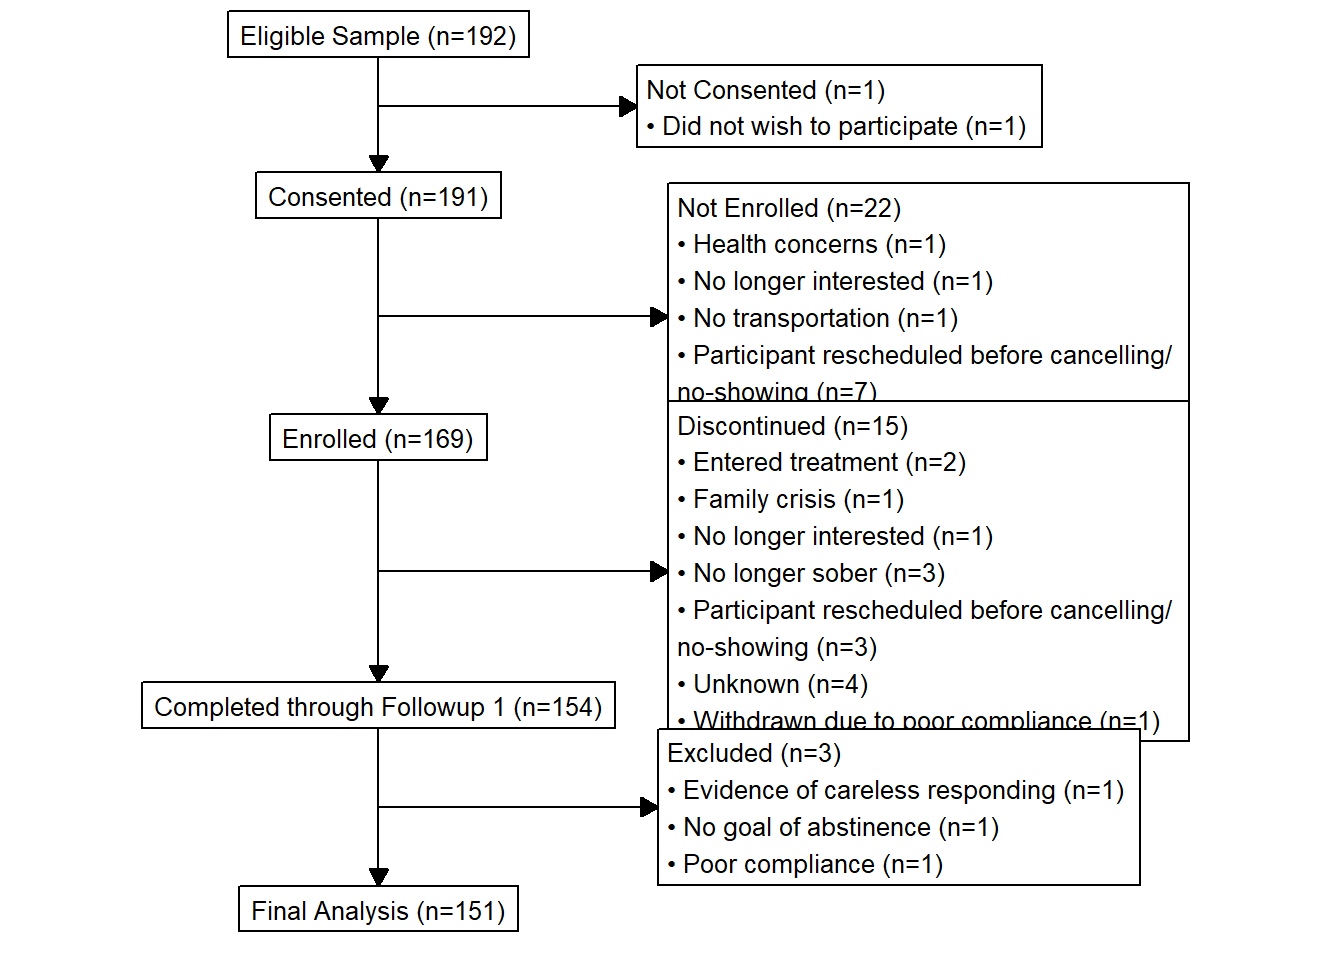
<figcaption>Figure 6: CONSORT diagram. The diagram depicts participant retention at each study milestone. It also displays reasons for discontinuation when known and reasons for data exclusions.</figcaption>
</figure>

<a href="#fig-ema-1x" class="quarto-xref">Figure 7</a> presents participant EMA completion percentages for at least one daily EMA.

``` python
week_compliance_all <- ema_week_compliance_4x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "4x Daily") |> 
  bind_rows(ema_week_compliance_1x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "1x Daily")) 


week_compliance_all |> 
  mutate(signal = factor(signal, levels = c("1x Daily", "4x Daily"))) |> 
  group_by(week, signal) |> 
  ggplot(aes(x = week, y = mean_compliance, group = signal, shape = signal)) +
  geom_point(size = 2) +
  geom_line() +
  geom_errorbar(aes(ymin = mean_compliance - se, ymax = mean_compliance + se), 
                width = .3, linewidth = .3) +
  theme_classic() +
  scale_shape_manual(values = c(19, 1, 17)) +
  scale_x_continuous(name = "Week", 
                     breaks = seq(1, 12, 1)) +
  scale_y_continuous(name = "Completion percentage", 
                     breaks = seq(0, 100, 10), 
                     limits = c(0, 100)) +
  geom_hline(aes(yintercept = mean_compliance), week_compliance_all |> 
               group_by(signal) |> 
               summarize(mean_compliance = mean(mean_compliance)),
             linetype = "dashed", linewidth = .3) +
  theme(legend.title = element_blank(),
        legend.position = "bottom")
```

<figure id="fig-ema-1x">
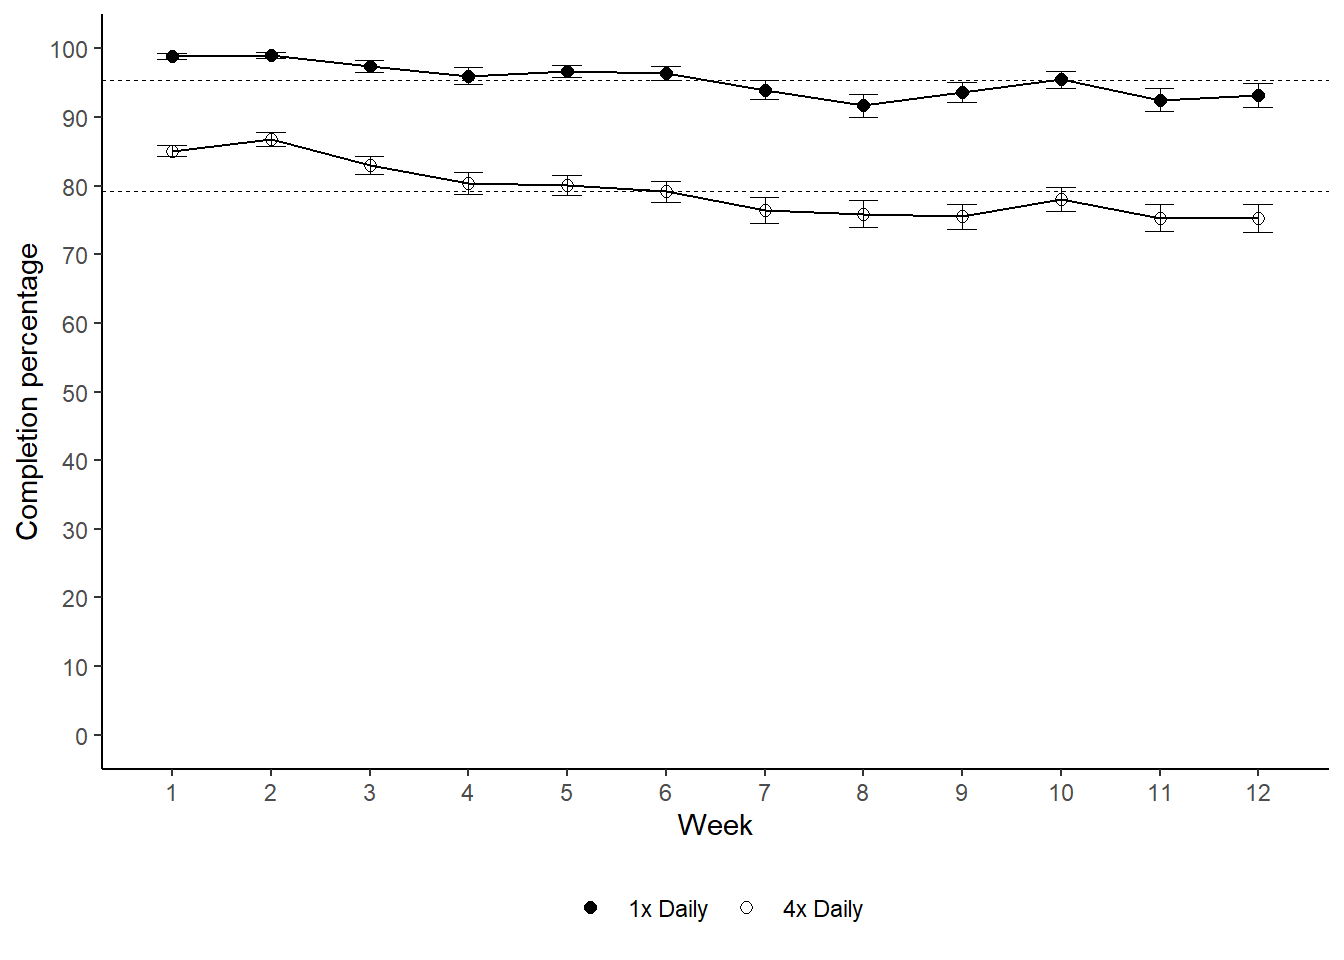
<figcaption>Figure 7: EMA completion by week. The plot depicts completion percentages over time (by week) across the study period for 1x (closed circles) and 4x (open circles) daily EMA. Dashed lines represent mean EMA completion over entire study period for 1x and 4x daily EMA. Error bars represent the standard error for each completion percentage by week.</figcaption>
</figure>

<a href="#fig-missing" class="quarto-xref">Figure 8</a> presents the proportion of missing data for all features by model.

``` python
feat_all |> 
  group_by(width) |> 
  summarize(across(everything(), ~mean(is.na(.x)))) |> 
  pivot_longer(cols = c(everything(), -width),
               names_to = "feature", values_to = "pct_miss") |> 
  ggplot(aes(x = pct_miss, color = width, fill = width)) +
  geom_histogram(alpha = .5, binwidth = .01) +
  facet_wrap("width") +
  theme(legend.position = "none") +
  xlab("Proportion of Missing Data") +
  ylab("Count")
```

<figure id="fig-missing">
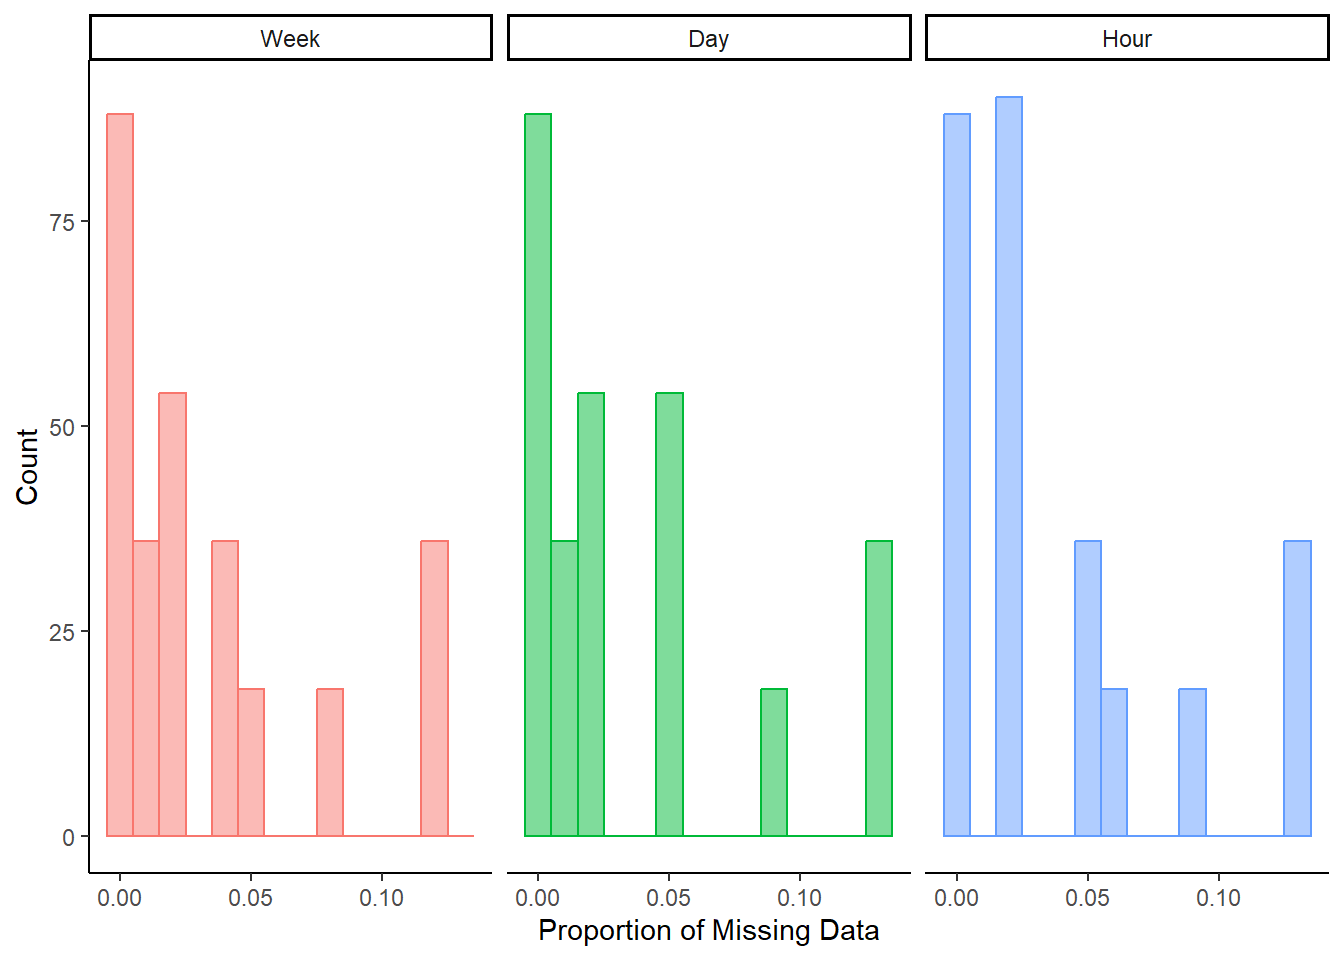
<figcaption>Figure 8: Histogram of proportion of missing data by model. The plot depicts histograms of the proportion of missing data across the 268 features for each full model (Week, Day, and Hour).</figcaption>
</figure>

<a href="#fig-roc-auc" class="quarto-xref">Figure 9</a> presents individual ROC curves and AUCs for the 30 held-out test sets.

``` python
plot_grid(fig_roc_week, fig_auc_week, fig_roc_day, fig_auc_day, fig_roc_hour, fig_auc_hour,
          ncol = 2, align = "h")
```

<figure id="fig-roc-auc">
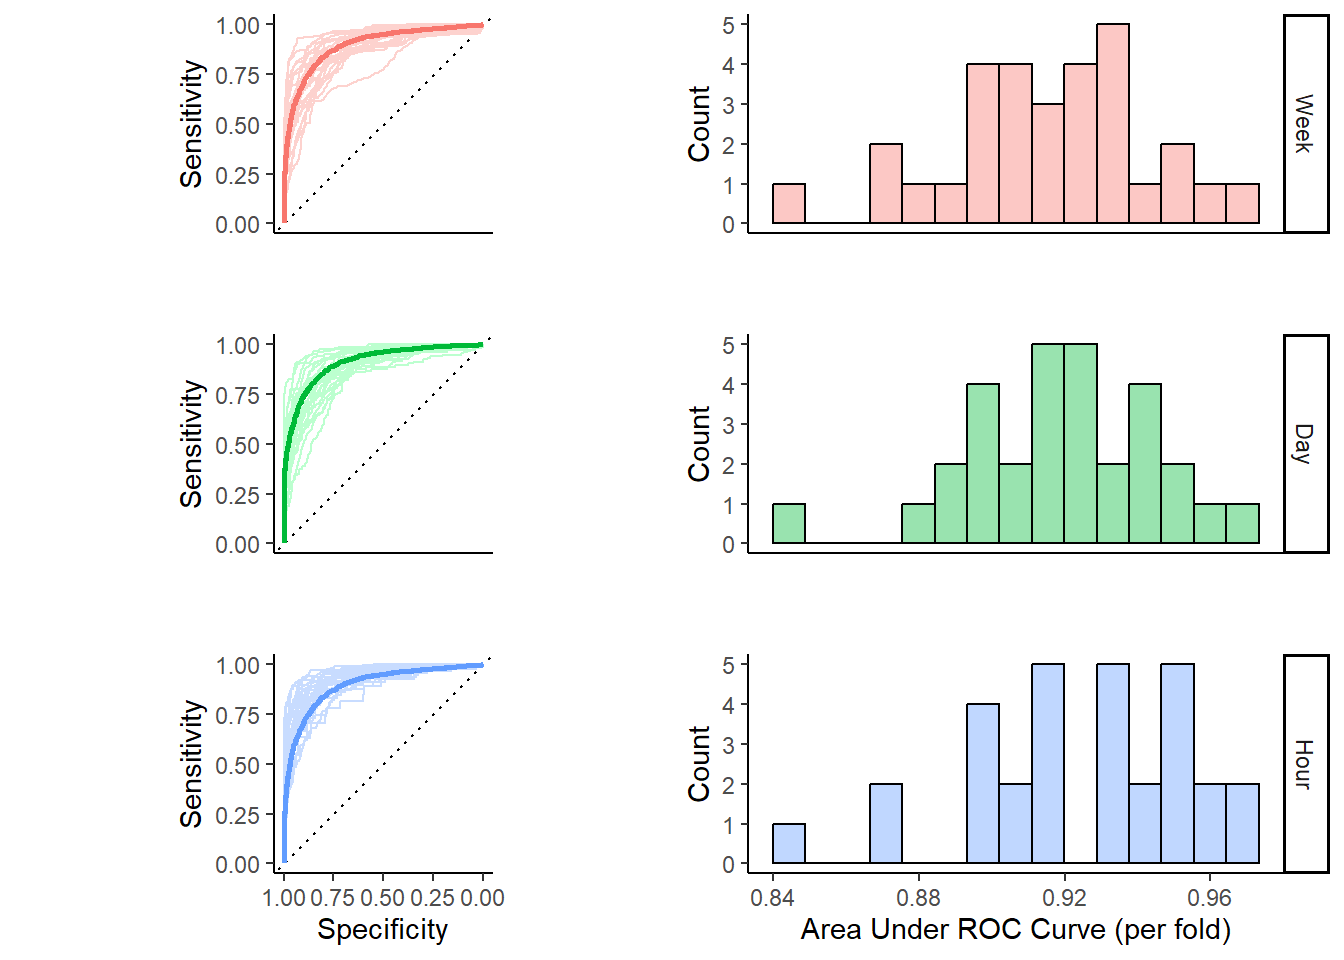
<figcaption>Figure 9: ROC curves and auROCs by model. The plots on the left depict individual receiver operating characteristic (ROC) curves from each of the 30 test sets. The darker curves represent the aggregate ROC curve derived by concatenating all held out folds. The dotted line represents the expected ROC curve for a random classifier. The histograms on the right depict the distribution of areas under the ROC curves (auROCs) from the same 30 test sets. The rows are organized by model (week, day, hour).</figcaption>
</figure>

<a href="#fig-preds" class="quarto-xref">Figure 10</a> presents histograms for the predicted probabilities of lapse for all observations in the 30 held-out test sets separately by prediction window and true outcome for the full models.

``` python
fig_preds_week_lapse <- preds_week |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Week") |> 
  filter(truth == "Lapse") |> 
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#F8766D", col = "black", alpha = .4) +
   facet_wrap(~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_week, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab("Count")

fig_preds_week_nolapse <- preds_week |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Week") |> 
  filter(truth == "No lapse") |> 
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#F8766D", col = "black", alpha = .4) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_week, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab("Count")


fig_preds_day_lapse <- preds_day |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Day") |> 
  filter(truth == "Lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#00BA38", col = "black", alpha = .4) +
   facet_wrap(~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_day, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab(NULL)

fig_preds_day_nolapse <- preds_day |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Day") |> 
  filter(truth == "No lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#00BA38", col = "black", alpha = .4) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_day, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab(NULL)

fig_preds_hour_lapse <- preds_hour |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Hour") |> 
  filter(truth == "Lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#619CFF", col = "black", alpha = .4) +
   facet_grid(truth~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_hour, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab(NULL)

fig_preds_hour_nolapse <- preds_hour |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Hour") |> 
  filter(truth == "No lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#619CFF", col = "black", alpha = .4) +
   facet_wrap(~truth, strip.position = "right") +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_hour, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab(NULL)


fig_week <- plot_grid(fig_preds_week_lapse, fig_preds_week_nolapse, ncol = 1, align = "v")
fig_day <- plot_grid(fig_preds_day_lapse, fig_preds_day_nolapse, ncol = 1, align = "v")
fig_hour <- plot_grid(fig_preds_hour_lapse, fig_preds_hour_nolapse, ncol = 1, align = "v")


plot_grid(fig_week, fig_day, fig_hour, nrow = 1, rel_widths = c(1, 1, 1.1))
```

<figure id="fig-preds">
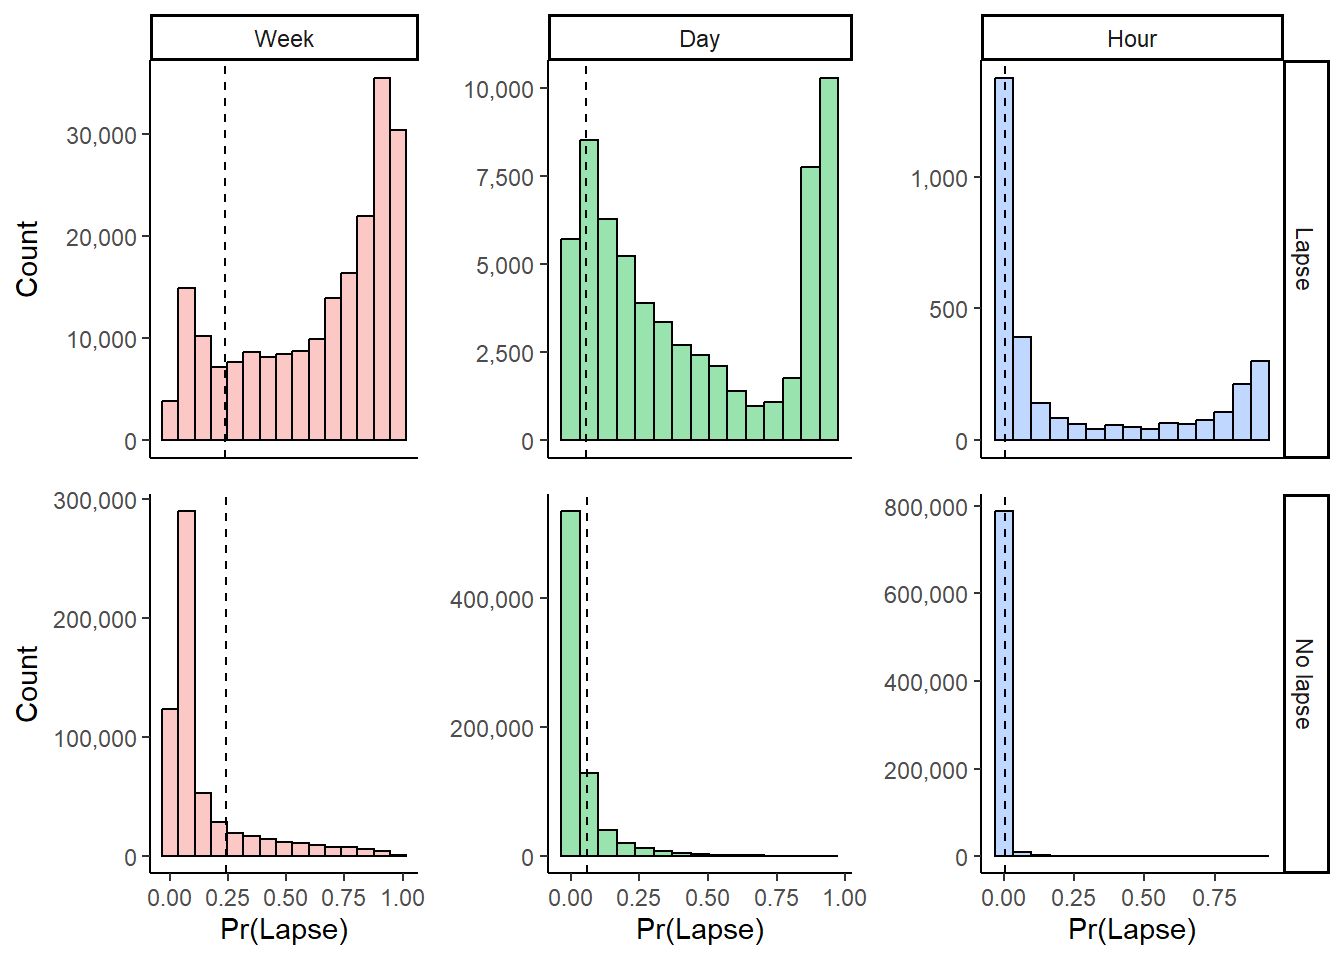
<figcaption>Figure 10: Lapse probability predictions by model. The plots above depict predicted probabilities for all observations in the 30 test sets. The columns are organized by model (week, day, hour). The top row depicts estimated lapse probabilities for true lapses. The bottom row depicts estimated lapse probabilities for true no lapses. The dashed vertical lines represent the decision threshold for each model, determined using Youden’s index.</figcaption>
</figure>

## 5.2 Chapter 3

[1] Features for income and employment were inadvertently excluded from all models.

[2] In early exploratory analyses, we evaluated auROCs of all four algorithms using grouped k-fold cross-validation for models based on preliminary feature engineering using the EMAs. XGBoost models consistently outperformed other algorithms such that we focused all further development on XGBoost to reduce the substantial computational time associated with model training and evaluation.

[3] Although XGBoost ignores participant-level information, we do leverage this information to some degree by including change features that anchor participants’ EMA responses to their own previous responses.

[4] Priors were set as follows: residual standard deviation ~ normal(location=0, scale=exp(2)), intercept (after centering predictors) ~ normal(location=2.3, scale=1.3), the two coefficients for window width contrasts ~ normal (location=0, scale=2.69), and covariance ~ decov(regularization=1, concentration=1, shape=1, scale=1).

[5] The poverty cutoff was defined from the 2024 federal poverty line for the 48 continguous United States. Participants at or below \$1560 annual income were categorized as below poverty.

[6] For our fairness analyses, we altered our outer loop resampling method from 3 x 10 cross-validation to 6 x 5 cross-validation. This method still gave us 30 held out tests sets, but by splitting the data across fewer folds (i.e., 5 vs. 10) we were able to reduce the likelihood of the disadvantaged group being absent in any single fold.